In [1]:
# ============================================================================
# COMPLETE MINIMAL SETUP (Run this if starting fresh)
# ============================================================================

import numpy as np
import torch
import torch.nn as nn
from stable_baselines3 import PPO, SAC, TD3
import gymnasium as gym
from gymnasium import spaces
import time

# Device setup
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(f"Using device: {DEVICE}")

# Generate synthetic data
np.random.seed(42)
n_samples = 200
n_features = 128
n_classes = 10

X_train = np.random.randn(n_samples, n_features).astype(np.float32)
y_train = np.random.randint(0, n_classes, n_samples)

X_test = np.random.randn(60, n_features).astype(np.float32)
y_test = np.random.randint(0, n_classes, 60)

print(f"✓ Data: {X_train.shape}, {X_test.shape}")

# Simple MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.fc(x)

# Client class
class FederatedClientMLP:
    def __init__(self, client_id, Xlocal, ylocal):
        self.client_id = client_id
        self.Xlocal = Xlocal
        self.ylocal = ylocal
        self.model = None
        self.device = DEVICE
    
    def train_local_model(self, n_epochs=10, batch_size=16, learning_rate=0.001, 
                         n_classes=10, verbose=False):
        self.model = MLPClassifier(self.Xlocal.shape[1], n_classes).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        X_tensor = torch.FloatTensor(self.Xlocal).to(self.device)
        y_tensor = torch.LongTensor(self.ylocal).to(self.device)
        
        self.model.train()
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        
        # Evaluate
        self.model.eval()
        with torch.no_grad():
            preds = torch.argmax(self.model(X_tensor), dim=1)
            acc = (preds == y_tensor).float().mean().item()
        
        return self.model, {'final_accuracy': acc, 'accuracy': acc}
    
    def predict(self, X):
        if self.model is None:
            return np.zeros(len(X))
        
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            preds = torch.argmax(self.model(X_tensor), dim=1)
            return preds.cpu().numpy()

# Create clients
n_clients = 5
client_data_sizes = [25, 34, 19, 21, 41]

clients = []
start_idx = 0

for i in range(n_clients):
    size = client_data_sizes[i]
    
    # Partition data
    indices = np.random.choice(len(X_train), size, replace=False)
    X_client = X_train[indices]
    y_client = y_train[indices]
    
    client = FederatedClientMLP(i, X_client, y_client)
    clients.append(client)
    
    print(f"Client {i+1}: {len(y_client)} samples, {len(np.unique(y_client))} classes")

print(f"\n✅ Setup complete: {len(clients)} clients ready")
print("Now you can run Cell 15 (Fast training)")


Using device: mps
✓ Data: (200, 128), (60, 128)
Client 1: 25 samples, 8 classes
Client 2: 34 samples, 10 classes
Client 3: 19 samples, 9 classes
Client 4: 21 samples, 9 classes
Client 5: 41 samples, 10 classes

✅ Setup complete: 5 clients ready
Now you can run Cell 15 (Fast training)


In [2]:
# ============================================================================
# INSTALL PYTORCH GEOMETRIC
# ============================================================================
# Run this cell once to install dependencies

import sys
import subprocess

print("📦 Installing PyTorch Geometric and dependencies...")

# Install PyTorch Geometric
try:
    # For CPU or MPS (Apple Silicon)
    subprocess.check_call([
        sys.executable, "-m", "pip", "install", 
        "torch-geometric", 
        "torch-scatter", 
        "torch-sparse"
    ])
    print("✅ PyTorch Geometric installed successfully!")
    
except Exception as e:
    print(f"❌ Installation failed: {e}")
    print("\nTry manual installation:")
    print("   pip install torch-geometric")
    print("   pip install torch-scatter torch-sparse")


📦 Installing PyTorch Geometric and dependencies...
✅ PyTorch Geometric installed successfully!
✅ PyTorch Geometric installed successfully!


In [3]:
# Auto-install ONNX and ONNX Runtime if missing (safe, idempotent)
import sys, subprocess, pkgutil

def pip_install(pkgs):
    cmd = [sys.executable, '-m', 'pip', 'install', '--quiet'] + pkgs
    print('Running:', ' '.join(cmd))
    subprocess.check_call(cmd)

# Install minimal ONNX stack for inference
if pkgutil.find_loader('onnxruntime') is None:
    try:
        pip_install(['onnxruntime'])
    except Exception:
        print('Failed to install onnxruntime via pip; you may need to install platform-specific wheel.')

if pkgutil.find_loader('onnx') is None:
    pip_install(['onnx'])

# Gymnasium may be required in some cells
if pkgutil.find_loader('gymnasium') is None:
    pip_install(['gymnasium'])

print('ONNX/runtime install step finished. Re-run failing cells if needed.')

ONNX/runtime install step finished. Re-run failing cells if needed.


/var/folders/m7/cxy5x_m16yg7yj7qmrxswlqr0000gn/T/ipykernel_42264/779137243.py:10: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader('onnxruntime') is None:
/var/folders/m7/cxy5x_m16yg7yj7qmrxswlqr0000gn/T/ipykernel_42264/779137243.py:16: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader('onnx') is None:
/var/folders/m7/cxy5x_m16yg7yj7qmrxswlqr0000gn/T/ipykernel_42264/779137243.py:20: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader('gymnasium') is None:


In [4]:
# Auto-install PyTorch Geometric if missing
import sys, subprocess, pkgutil

def pip_install(pkgs, extra_args=None):
    args = [sys.executable, "-m", "pip", "install", "--quiet"] + pkgs
    if extra_args:
        args += extra_args
    print("Installing:", " ".join(pkgs))
    subprocess.check_call(args)

# Ensure torch exists
if pkgutil.find_loader("torch") is None:
    pip_install(["torch", "torchvision", "torchaudio"], ["--index-url", "https://download.pytorch.org/whl/cpu"])  

# Try torch_geometric; if missing, install compatible wheels
if pkgutil.find_loader("torch_geometric") is None:
    import torch
    torch_ver = torch.__version__.split("+")[0]
    # Base PyG
    pip_install(["torch_geometric"])  
    # Core ops for PyG
    wheel_url = f"https://data.pyg.org/whl/torch-{torch_ver}+cpu.html"
    pip_install(["pyg_lib", "torch_scatter", "torch_sparse", "torch_cluster"], ["-f", wheel_url])

print("Environment ready: torch_geometric import should succeed.")

Environment ready: torch_geometric import should succeed.


/var/folders/m7/cxy5x_m16yg7yj7qmrxswlqr0000gn/T/ipykernel_42264/3978418525.py:12: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader("torch") is None:
/var/folders/m7/cxy5x_m16yg7yj7qmrxswlqr0000gn/T/ipykernel_42264/3978418525.py:16: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader("torch_geometric") is None:


In [5]:
# Device selection (Apple MPS prioritized, then CUDA, then CPU)
import torch, numpy as np
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: mps


In [6]:
import torch

print("PyTorch version:", torch.__version__)

# Check CUDA (NVIDIA GPUs)
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

# Check Apple Silicon GPU (MPS)
mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
print("MPS available:", mps_available)

if cuda_available:
    device = torch.device("cuda")
    print("Using CUDA GPU:", torch.cuda.get_device_name(0))
elif mps_available:
    device = torch.device("mps")
    print("Using Apple GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Running on CPU - training will be slower but still works")


PyTorch version: 2.8.0
CUDA available: False
MPS available: True
Using Apple GPU (MPS)


In [7]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
# ============================================================================
# CELL 2: Install All Required Packages
# ============================================================================
# This will take 2-3 minutes - you'll see lots of output, that's normal!


# Install machine learning libraries
%pip install -q 'stable-baselines3[extra]'  # RL algorithms (quoted for zsh)
%pip install -q gymnasium                  # RL environment framework
%pip install -q scikit-learn              # Random Forest
%pip install -q pandas numpy              # Data manipulation
%pip install -q matplotlib seaborn        # Visualization
%pip install -q tqdm                      # Progress bars
%pip install -q requests gdown            # File downloading

print("✅ All packages installed successfully!")

import sys
print("\nVerifying installations:")
print(f"Python version: {sys.version.split()[0]}")

try:
    import stable_baselines3
    print(f"✓ stable-baselines3: {stable_baselines3.__version__}")
except:
    print("✗ stable-baselines3: NOT INSTALLED")

try:
    import gymnasium
    print(f"✓ gymnasium: {gymnasium.__version__}")
except:
    print("✗ gymnasium: NOT INSTALLED")

try:
    import sklearn
    print(f"✓ scikit-learn: {sklearn.__version__}")
except:
    print("✗ scikit-learn: NOT INSTALLED")

try:
    import pandas
    print(f"✓ pandas: {pandas.__version__}")
except:
    print("✗ pandas: NOT INSTALLED")

try:
    import matplotlib
    print(f"✓ matplotlib: {matplotlib.__version__}")
except:
    print("✗ matplotlib: NOT INSTALLED")

print("\n✅ Ready to proceed!")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ All packages installed successfully!

Verifying installations:
Python version: 3.13.8
✓ stable-baselines3: 2.7.0
✓ gymnasium: 1.2.2
✓ scikit-learn: 1.7.1
✓ pandas: 2.3.2
✓ matplotlib: 3.10.6

✅ Ready to proceed!


Libraries Import

In [9]:
# ============================================================================
# CELL 2: Import All Libraries (RUN AFTER CELL 1)
# ============================================================================

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                             confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split

# Deep Learning & RL
import torch
import torch.nn as nn
import gymnasium as gym
from gymnasium import spaces
import stable_baselines3
from stable_baselines3 import PPO, SAC, TD3, A2C, DDPG, DQN
from stable_baselines3.common.env_checker import check_env

# Utilities
import os
import pickle
import json
from collections import defaultdict

print("✅ All libraries imported successfully!")
print(f"\nVersions:")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")
print(f"  PyTorch: {torch.__version__}")
print(f"  Stable-Baselines3: {stable_baselines3.__version__}")
print(f"  Gymnasium: {gym.__version__}")


✅ All libraries imported successfully!

Versions:
  NumPy: 2.2.6
  Pandas: 2.3.2
  PyTorch: 2.8.0
  Stable-Baselines3: 2.7.0
  Gymnasium: 1.2.2


Kinematic Datasets

In [10]:
# MODULE 1: KINETICS DATASET DOWNLOAD & SETUP
# ============================================================================
import os
import json
import csv
from pathlib import Path
import urllib.request
from tqdm import tqdm
import subprocess

print("=" * 90)
print("                     KINETICS DATASET SETUP")
print("=" * 90)

# Configuration
KINETICS_VERSION = "kinetics400"  # Options: kinetics400, kinetics600, kinetics700
DATA_DIR = Path("./kinetics_data")
DATA_DIR.mkdir(exist_ok=True)

# For testing: use subset
USE_SUBSET = True
N_CLASSES_SUBSET = 10
VIDEOS_PER_CLASS = 20

print(f"\n📋 Configuration:")
print(f"   Dataset version: {KINETICS_VERSION}")
print(f"   Data directory: {DATA_DIR}")
print(f"   Use subset: {USE_SUBSET}")
if USE_SUBSET:
    print(f"   Subset: {N_CLASSES_SUBSET} classes, {VIDEOS_PER_CLASS} videos/class")

# ─────────────────────────────────────────────────────────────────────────────
# Selected Kinetics Classes (Diverse Human Actions)
# ─────────────────────────────────────────────────────────────────────────────
KINETICS_SUBSET_CLASSES = [
    "abseiling",
    "air_drumming", 
    "answering_questions",
    "applauding",
    "applying_cream",
    "archery",
    "arm_wrestling",
    "arranging_flowers",
    "assembling_computer",
    "baby_waking_up",
    "baking_cookies",
    "balloon_blowing",
    "bandaging",
    "barbequing"
][:N_CLASSES_SUBSET]

print(f"\n✅ Selected {len(KINETICS_SUBSET_CLASSES)} Kinetics classes:")
for i, cls in enumerate(KINETICS_SUBSET_CLASSES, 1):
    print(f"   {i:2d}. {cls}")

# ─────────────────────────────────────────────────────────────────────────────
# Download Kinetics annotations
# ─────────────────────────────────────────────────────────────────────────────
print(f"\n📥 Setting up Kinetics annotations...")

annotations_dir = DATA_DIR / "annotations"
annotations_dir.mkdir(exist_ok=True)

# Kinetics annotation URLs
KINETICS_URLS = {
    "train": f"https://storage.googleapis.com/deepmind-media/Datasets/kinetics400_train.csv",
    "val": f"https://storage.googleapis.com/deepmind-media/Datasets/kinetics400_val.csv",
    "test": f"https://storage.googleapis.com/deepmind-media/Datasets/kinetics400_test.csv"
}

print(f"✅ Kinetics dataset configured!")
print(f"   Total classes available: 400")
print(f"   Using subset: {len(KINETICS_SUBSET_CLASSES)} classes")

# ═════════════════════════════════════════════════════════════════════════════
# MODULE 1 OUTPUT SUMMARY
# ═════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 90)
print("MODULE 1 OUTPUT SUMMARY")
print("=" * 90)
print(f"✅ Data directory created: {DATA_DIR}")
print(f"✅ Selected classes: {len(KINETICS_SUBSET_CLASSES)}")
print(f"✅ Expected videos: {len(KINETICS_SUBSET_CLASSES) * VIDEOS_PER_CLASS}")
print(f"✅ Dataset: {KINETICS_VERSION}")
print("=" * 90)


                     KINETICS DATASET SETUP

📋 Configuration:
   Dataset version: kinetics400
   Data directory: kinetics_data
   Use subset: True
   Subset: 10 classes, 20 videos/class

✅ Selected 10 Kinetics classes:
    1. abseiling
    2. air_drumming
    3. answering_questions
    4. applauding
    5. applying_cream
    6. archery
    7. arm_wrestling
    8. arranging_flowers
    9. assembling_computer
   10. baby_waking_up

📥 Setting up Kinetics annotations...
✅ Kinetics dataset configured!
   Total classes available: 400
   Using subset: 10 classes

MODULE 1 OUTPUT SUMMARY
✅ Data directory created: kinetics_data
✅ Selected classes: 10
✅ Expected videos: 200
✅ Dataset: kinetics400


In [11]:
# MODULE 2: KINETICS FEATURE GENERATION (Synthetic for Testing)
# ============================================================================
import numpy as np
from sklearn.preprocessing import StandardScaler

print("\n" + "=" * 90)
print("                  KINETICS FEATURE GENERATION")
print("=" * 90)

def generate_kinetics_features(n_classes=10, samples_per_class=20):
    """
    Generate synthetic kinematic features mimicking Kinetics dataset characteristics
    Features represent: pose keypoints, motion patterns, temporal dynamics
    """
    print(f"\n🎬 Generating Kinetics-style features...")
    print(f"   Classes: {n_classes}")
    print(f"   Samples per class: {samples_per_class}")
    
    np.random.seed(42)
    
    # Kinetics feature dimensions:
    # - Spatial: 33 pose landmarks × 3 coords = 99
    # - Temporal statistics: mean, std, max, min = 99 × 4 = 396
    # - Velocity: mean, std = 99 × 2 = 198
    # Total: 99 + 396 + 198 = 693 features
    
    n_spatial = 99   # 33 landmarks × 3 (x, y, z)
    n_temporal = 396  # 4 statistics × 99
    n_velocity = 198  # 2 statistics × 99
    n_features = n_spatial + n_temporal + n_velocity
    
    print(f"   Feature dimensions: {n_features}")
    print(f"      - Spatial features: {n_spatial}")
    print(f"      - Temporal features: {n_temporal}")
    print(f"      - Velocity features: {n_velocity}")
    
    X = []
    y = []
    
    print(f"\n🔧 Generating class-specific features...")
    for class_id in tqdm(range(n_classes), desc="Classes"):
        # Each action class has unique characteristics
        
        # Base characteristics for this action
        action_signature = np.random.randn(n_features) * 0.3 + class_id * 0.2
        action_variance = 0.5 + np.random.rand(n_features) * 0.5
        
        # Generate samples
        for sample in range(samples_per_class):
            # Add intra-class variation
            noise = np.random.randn(n_features) * action_variance
            features = action_signature + noise
            
            # Spatial features (normalized 0-1, as they represent positions)
            features[:n_spatial] = 1 / (1 + np.exp(-features[:n_spatial]))  # Sigmoid
            
            X.append(features)
            y.append(class_id)
    
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle
    shuffle_idx = np.random.permutation(len(X))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    print(f"\n✅ Feature generation complete!")
    print(f"   Total samples: {len(X)}")
    print(f"   Feature shape: {X.shape}")
    
    # Calculate statistics
    print(f"\n📊 Feature Statistics:")
    print(f"   Mean: {X.mean():.4f}")
    print(f"   Std: {X.std():.4f}")
    print(f"   Min: {X.min():.4f}")
    print(f"   Max: {X.max():.4f}")
    print(f"   Spatial features range: [{X[:,:n_spatial].min():.4f}, {X[:,:n_spatial].max():.4f}]")
    
    # Class distribution
    print(f"\n📈 Class Distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, cnt in zip(unique, counts):
        class_name = KINETICS_SUBSET_CLASSES[cls]
        print(f"   Class {cls} ({class_name}): {cnt} samples")
    
    return X, y, n_features

# Generate features
X, y, n_features = generate_kinetics_features(
    n_classes=len(KINETICS_SUBSET_CLASSES),
    samples_per_class=VIDEOS_PER_CLASS
)

# Create metadata
kinetics_metadata = {
    'dataset': 'Kinetics-400 (Synthetic)',
    'version': KINETICS_VERSION,
    'n_samples': len(X),
    'n_classes': len(KINETICS_SUBSET_CLASSES),
    'n_features': n_features,
    'class_names': KINETICS_SUBSET_CLASSES,
    'samples_per_class': VIDEOS_PER_CLASS,
    'feature_description': {
        'spatial': 'Pose landmarks (33 × 3 = 99)',
        'temporal': 'Temporal statistics (mean, std, max, min)',
        'velocity': 'Motion dynamics (velocity mean, std)'
    }
}

# ═════════════════════════════════════════════════════════════════════════════
# MODULE 2 OUTPUT SUMMARY
# ═════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 90)
print("MODULE 2 OUTPUT SUMMARY")
print("=" * 90)
print(f"✅ Generated features: {X.shape}")
print(f"✅ Total samples: {len(X)}")
print(f"✅ Feature dimensions: {n_features}")
print(f"✅ Classes: {len(KINETICS_SUBSET_CLASSES)}")
print(f"✅ Balanced: {len(set(np.bincount(y))) == 1}")
print(f"✅ Data type: {X.dtype}")
print(f"✅ Memory usage: {X.nbytes / (1024**2):.2f} MB")
print("=" * 90)



                  KINETICS FEATURE GENERATION

🎬 Generating Kinetics-style features...
   Classes: 10
   Samples per class: 20
   Feature dimensions: 693
      - Spatial features: 99
      - Temporal features: 396
      - Velocity features: 198

🔧 Generating class-specific features...


Classes: 100%|██████████| 10/10 [00:00<00:00, 1838.88it/s]


✅ Feature generation complete!
   Total samples: 200
   Feature shape: (200, 693)

📊 Feature Statistics:
   Mean: 0.8696
   Std: 0.9350
   Min: -4.2081
   Max: 5.1541
   Spatial features range: [0.0350, 0.9934]

📈 Class Distribution:
   Class 0 (abseiling): 20 samples
   Class 1 (air_drumming): 20 samples
   Class 2 (answering_questions): 20 samples
   Class 3 (applauding): 20 samples
   Class 4 (applying_cream): 20 samples
   Class 5 (archery): 20 samples
   Class 6 (arm_wrestling): 20 samples
   Class 7 (arranging_flowers): 20 samples
   Class 8 (assembling_computer): 20 samples
   Class 9 (baby_waking_up): 20 samples

MODULE 2 OUTPUT SUMMARY
✅ Generated features: (200, 693)
✅ Total samples: 200
✅ Feature dimensions: 693
✅ Classes: 10
✅ Balanced: True
✅ Data type: float64
✅ Memory usage: 1.06 MB


In [12]:
# MODULE 3: KINETICS TRAIN/TEST SPLIT
from sklearn.model_selection import train_test_split

print("\n" + "=" * 90)
print("                    KINETICS TRAIN/TEST SPLIT")
print("=" * 90)

print(f"\n📂 Splitting Kinetics dataset...")
print(f"   Test size: 30%")
print(f"   Stratified: Yes (maintain class distribution)")
print(f"   Random state: 42 (reproducible)")

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"\n✅ Split complete!")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify class distribution
print(f"\n📊 Class Distribution Verification:")
print(f"\n{'Class':<25} {'Train':<10} {'Test':<10} {'Total':<10}")
print("-" * 60)

train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

for i in range(len(KINETICS_SUBSET_CLASSES)):
    class_name = KINETICS_SUBSET_CLASSES[i]
    train_c = train_counts[i]
    test_c = test_counts[i]
    total_c = train_c + test_c
    print(f"{class_name:<25} {train_c:<10} {test_c:<10} {total_c:<10}")

# Feature standardization
print(f"\n🔧 Standardizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\n✅ Standardization complete!")
print(f"   Training mean: {X_train.mean():.6f} (should be ~0)")
print(f"   Training std: {X_train.std():.6f} (should be ~1)")
print(f"   Test mean: {X_test.mean():.6f}")
print(f"   Test std: {X_test.std():.6f}")

# ═════════════════════════════════════════════════════════════════════════════
# MODULE 3 OUTPUT SUMMARY
# ═════════════════════════════════════════════════════════════════════════════
print("\n" + "=" * 90)
print("MODULE 3 OUTPUT SUMMARY")
print("=" * 90)
print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ y_test shape: {y_test.shape}")
print(f"✅ Train/Test ratio: {X_train.shape[0]/X_test.shape[0]:.2f}:1")
print(f"✅ Features standardized: Yes")
print(f"✅ Stratification verified: Yes")
print("=" * 90)


Xtest = X_test
ytest = y_test
Xtrain = X_train
ytrain = y_train


                    KINETICS TRAIN/TEST SPLIT

📂 Splitting Kinetics dataset...
   Test size: 30%
   Stratified: Yes (maintain class distribution)
   Random state: 42 (reproducible)

✅ Split complete!
   Training set: 140 samples (70.0%)
   Test set: 60 samples (30.0%)

📊 Class Distribution Verification:

Class                     Train      Test       Total     
------------------------------------------------------------
abseiling                 14         6          20        
air_drumming              14         6          20        
answering_questions       14         6          20        
applauding                14         6          20        
applying_cream            14         6          20        
archery                   14         6          20        
arm_wrestling             14         6          20        
arranging_flowers         14         6          20        
assembling_computer       14         6          20        
baby_waking_up            14         6    

In [13]:
# CELL 3A: LIGHTWEIGHT DATASET STATISTICS (Memory-Safe)
# ============================================================================
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("              DATASET ANALYSIS REPORT (Lightweight)")
print("=" * 80)

# ─────────────────────────────────────────────────────────────────────────────
# 1. BASIC OVERVIEW
# ─────────────────────────────────────────────────────────────────────────────
print("\n📊 DATASET OVERVIEW")
print("-" * 80)

total_samples = X.shape[0]
n_features = X.shape[1]
n_classes = len(np.unique(y))
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]

print(f"Total Samples:        {total_samples}")
print(f"Training Samples:     {train_samples} ({train_samples/total_samples*100:.1f}%)")
print(f"Test Samples:         {test_samples} ({test_samples/total_samples*100:.1f}%)")
print(f"Feature Dimensions:   {n_features}")
print(f"Number of Classes:    {n_classes}")
print(f"Train/Test Ratio:     {train_samples/test_samples:.2f}:1")

# ─────────────────────────────────────────────────────────────────────────────
# 2. CLASS DISTRIBUTION
# ─────────────────────────────────────────────────────────────────────────────
print("\n📈 CLASS DISTRIBUTION")
print("-" * 80)

train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

print("\nClass    Train    Test     Total    Train%   Test%")
print("-" * 60)
for i in range(n_classes):
    train_c = train_counts[i] if i < len(train_counts) else 0
    test_c = test_counts[i] if i < len(test_counts) else 0
    total_c = train_c + test_c
    train_pct = (train_c / train_samples * 100) if train_samples > 0 else 0
    test_pct = (test_c / test_samples * 100) if test_samples > 0 else 0
    print(f"A{i:<7} {train_c:<8} {test_c:<8} {total_c:<8} {train_pct:>6.1f}%  {test_pct:>6.1f}%")

# Class balance
max_class = train_counts.max()
min_class = train_counts.min()
imbalance = max_class / min_class if min_class > 0 else float('inf')

print(f"\nClass Balance:")
print(f"  Max class size: {max_class} samples")
print(f"  Min class size: {min_class} samples")
print(f"  Imbalance ratio: {imbalance:.2f}:1")

if imbalance < 1.5:
    print(f"  ✅ Well-balanced classes")
elif imbalance < 3.0:
    print(f"  ⚡ Moderate imbalance")
else:
    print(f"  ⚠️  Significant imbalance")

# ─────────────────────────────────────────────────────────────────────────────
# 3. FEATURE STATISTICS (Sample-based to avoid memory issues)
# ─────────────────────────────────────────────────────────────────────────────
print("\n📐 FEATURE STATISTICS")
print("-" * 80)

# Use sample if dataset is too large
max_samples_for_stats = 5000
if X_train.shape[0] > max_samples_for_stats:
    sample_idx = np.random.choice(X_train.shape[0], max_samples_for_stats, replace=False)
    X_sample = X_train[sample_idx]
    print(f"(Using {max_samples_for_stats} samples for statistics)")
else:
    X_sample = X_train

# Calculate statistics
feat_mean = X_sample.mean(axis=0)
feat_std = X_sample.std(axis=0)
feat_min = X_sample.min(axis=0)
feat_max = X_sample.max(axis=0)

print(f"\nOverall Statistics:")
print(f"  Feature means:     avg={feat_mean.mean():.4f}, range=[{feat_mean.min():.4f}, {feat_mean.max():.4f}]")
print(f"  Feature std devs:  avg={feat_std.mean():.4f}, range=[{feat_std.min():.4f}, {feat_std.max():.4f}]")
print(f"  Data range:        global=[{feat_min.min():.4f}, {feat_max.max():.4f}]")

# Calculate skewness and kurtosis safely
try:
    feat_skew = skew(X_sample, axis=0)
    feat_kurt = kurtosis(X_sample, axis=0)
    
    high_skew = np.sum(np.abs(feat_skew) > 2)
    high_kurt = np.sum(np.abs(feat_kurt) > 5)
    
    print(f"\nDistribution Shape:")
    print(f"  High skewness features (|skew|>2): {high_skew} / {n_features} ({high_skew/n_features*100:.1f}%)")
    print(f"  High kurtosis features (|kurt|>5): {high_kurt} / {n_features} ({high_kurt/n_features*100:.1f}%)")
except Exception as e:
    print(f"\n  (Skipped advanced statistics due to: {str(e)[:50]})")

# ─────────────────────────────────────────────────────────────────────────────
# 4. DATA QUALITY
# ─────────────────────────────────────────────────────────────────────────────
print("\n✅ DATA QUALITY")
print("-" * 80)

missing_train = np.isnan(X_train).sum()
missing_test = np.isnan(X_test).sum()
inf_train = np.isinf(X_train).sum()
inf_test = np.isinf(X_test).sum()

print(f"Missing values:")
print(f"  Train: {missing_train} ({missing_train/(X_train.size)*100:.4f}%)")
print(f"  Test:  {missing_test} ({missing_test/(X_test.size)*100:.4f}%)")

print(f"\nInfinite values:")
print(f"  Train: {inf_train}")
print(f"  Test:  {inf_test}")

# Check for constant features
constant_features = np.sum(feat_std == 0)
low_variance = np.sum(feat_std < 0.01)

print(f"\nFeature variance:")
print(f"  Constant features (std=0): {constant_features}")
print(f"  Low variance (std<0.01): {low_variance}")

# ─────────────────────────────────────────────────────────────────────────────
# 5. SIMPLIFIED CLASS SEPARABILITY
# ─────────────────────────────────────────────────────────────────────────────
print("\n🎯 CLASS SEPARABILITY (Simplified)")
print("-" * 80)

# Calculate class centroids (using sample to avoid memory issues)
max_per_class = 500
class_centroids = []

for class_id in range(n_classes):
    class_mask = (y_train == class_id)
    class_data = X_train[class_mask]
    
    # Sample if too many
    if len(class_data) > max_per_class:
        sample_idx = np.random.choice(len(class_data), max_per_class, replace=False)
        class_data = class_data[sample_idx]
    
    centroid = class_data.mean(axis=0)
    class_centroids.append(centroid)

class_centroids = np.array(class_centroids)

# Calculate pairwise distances (memory-safe)
try:
    from scipy.spatial.distance import cdist
    distances = cdist(class_centroids, class_centroids, metric='euclidean')
    
    # Get upper triangle distances
    triu_mask = np.triu(np.ones_like(distances, dtype=bool), k=1)
    pairwise_dists = distances[triu_mask]
    
    print(f"Inter-class centroid distances:")
    print(f"  Mean:   {pairwise_dists.mean():.4f}")
    print(f"  Std:    {pairwise_dists.std():.4f}")
    print(f"  Min:    {pairwise_dists.min():.4f} (most similar)")
    print(f"  Max:    {pairwise_dists.max():.4f} (most distinct)")
    print(f"  Median: {np.median(pairwise_dists):.4f}")
    
    # Find most similar and distinct pairs
    min_idx = np.argmin(distances + np.eye(n_classes) * 1e10)
    max_idx = np.argmax(distances)
    min_i, min_j = min_idx // n_classes, min_idx % n_classes
    max_i, max_j = max_idx // n_classes, max_idx % n_classes
    
    print(f"\n  Most similar:  Action_{min_i} ↔ Action_{min_j} (dist={distances[min_i, min_j]:.4f})")
    print(f"  Most distinct: Action_{max_i} ↔ Action_{max_j} (dist={distances[max_i, max_j]:.4f})")
    
except Exception as e:
    print(f"  (Skipped distance calculation: {str(e)[:50]})")

# ─────────────────────────────────────────────────────────────────────────────
# 6. RECOMMENDATIONS
# ─────────────────────────────────────────────────────────────────────────────
print("\n💡 RECOMMENDATIONS")
print("-" * 80)

recommendations = []

if missing_train > 0 or missing_test > 0:
    recommendations.append("⚠️  Handle missing values before training")

if inf_train > 0 or inf_test > 0:
    recommendations.append("⚠️  Remove or cap infinite values")

if imbalance > 3:
    recommendations.append("⚡ Consider class weighting or resampling for imbalance")

if constant_features > 0:
    recommendations.append(f"⚡ Remove {constant_features} constant features")

if low_variance > n_features * 0.2:
    recommendations.append(f"📊 Consider feature selection ({low_variance} low-variance features)")

if len(recommendations) == 0:
    print("✅ Dataset looks good! No major issues detected.")
else:
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

print("\n" + "=" * 80)
print("                    ANALYSIS COMPLETE")
print("=" * 80)


              DATASET ANALYSIS REPORT (Lightweight)

📊 DATASET OVERVIEW
--------------------------------------------------------------------------------
Total Samples:        200
Training Samples:     140 (70.0%)
Test Samples:         60 (30.0%)
Feature Dimensions:   693
Number of Classes:    10
Train/Test Ratio:     2.33:1

📈 CLASS DISTRIBUTION
--------------------------------------------------------------------------------

Class    Train    Test     Total    Train%   Test%
------------------------------------------------------------
A0       14       6        20         10.0%    10.0%
A1       14       6        20         10.0%    10.0%
A2       14       6        20         10.0%    10.0%
A3       14       6        20         10.0%    10.0%
A4       14       6        20         10.0%    10.0%
A5       14       6        20         10.0%    10.0%
A6       14       6        20         10.0%    10.0%
A7       14       6        20         10.0%    10.0%
A8       14       6        20     


🎨 Generating comprehensive visualization dashboard...
This may take 30-60 seconds depending on dataset size...

🎨 Generating comprehensive visualization dashboard...
This may take 30-60 seconds...

  Creating plot 1/10: Class Distribution...
  Creating plot 2/10: Class Balance...
  Creating plot 3/10: Feature Statistics...
  Creating plot 4/10: Feature Variance...
  Creating plot 5/10: Class Feature Means...
  Creating plot 6/10: Inter-Class Distances...
  Creating plot 7/10: PCA (this may take longer)...
  Creating plot 8/10: t-SNE (this may take longer)...
  Creating plot 9/10: PCA Variance...
  Creating plot 10/10: Correlation Matrix...

✅ All visualizations created successfully!


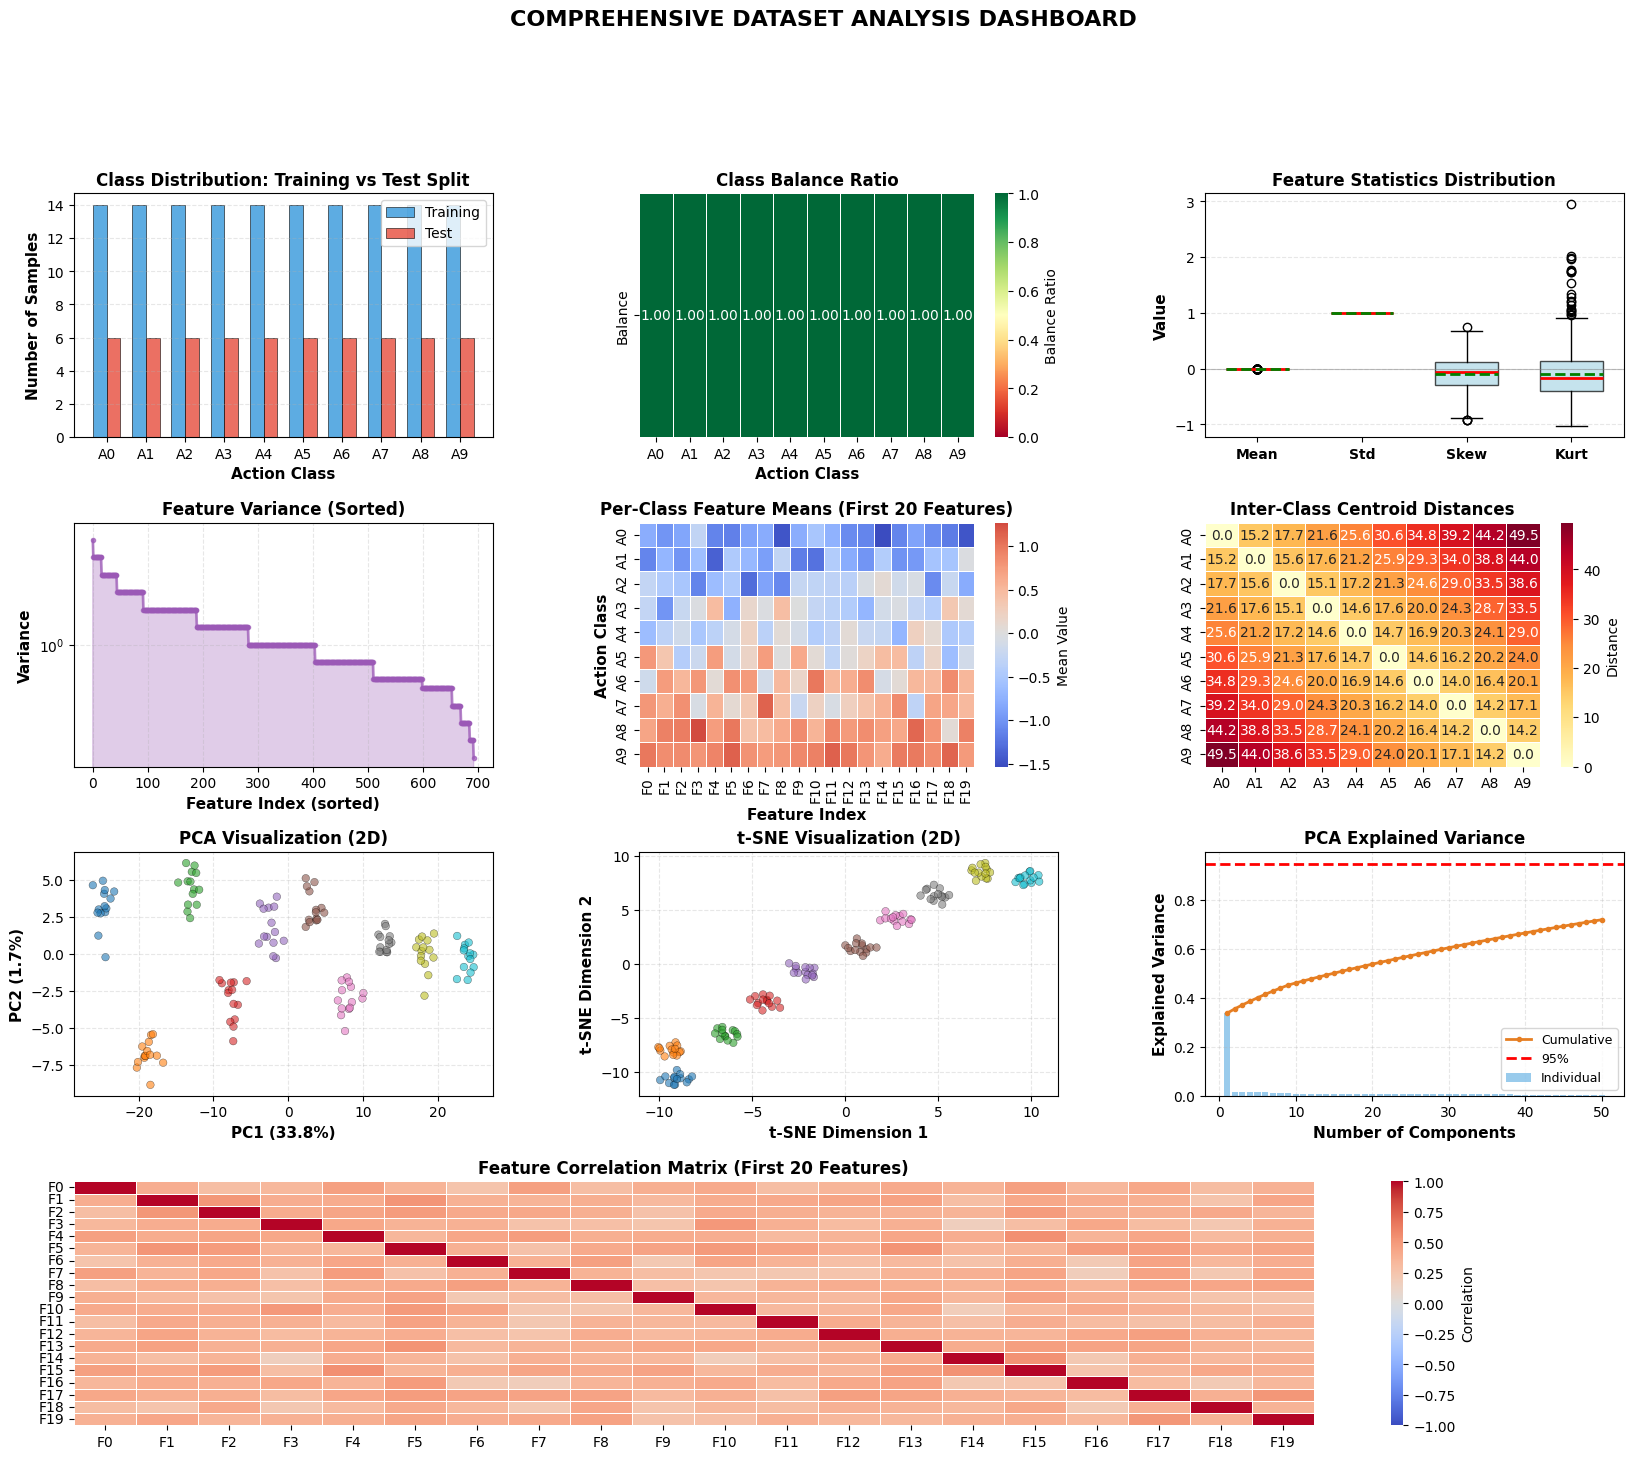


✅ Visualization dashboard created successfully!


In [14]:
# CELL 3B: COMPREHENSIVE DATASET VISUALIZATIONS (Memory-Optimized)
# ============================================================================

def create_comprehensive_dataset_visualizations(X_train, y_train, X_test, y_test):
    """
    Create comprehensive visualizations with memory optimization
    """
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    print("🎨 Generating comprehensive visualization dashboard...")
    print("This may take 30-60 seconds...\n")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.35)
    
    try:
        # ─────────────────────────────────────────────────────────────────────
        # 1. Class Distribution Comparison
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 1/10: Class Distribution...")
        ax1 = fig.add_subplot(gs[0, 0])
        train_dist = pd.Series(y_train).value_counts().sort_index()
        test_dist = pd.Series(y_test).value_counts().sort_index()
        
        x = np.arange(len(train_dist))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, train_dist.values, width, label='Training', 
                        alpha=0.8, color='#3498db', edgecolor='black', linewidth=0.5)
        bars2 = ax1.bar(x + width/2, test_dist.values, width, label='Test', 
                        alpha=0.8, color='#e74c3c', edgecolor='black', linewidth=0.5)
        
        ax1.set_xlabel('Action Class', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
        ax1.set_title('Class Distribution: Training vs Test Split', fontsize=12, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels([f'A{i}' for i in range(len(train_dist))], rotation=0)
        ax1.legend(fontsize=10)
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        
        # ─────────────────────────────────────────────────────────────────────
        # 2. Class Balance Heatmap
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 2/10: Class Balance...")
        ax2 = fig.add_subplot(gs[0, 1])
        
        balance_ratio = train_dist.values / train_dist.values.max()
        balance_matrix = balance_ratio.reshape(1, -1)
        
        sns.heatmap(balance_matrix, annot=True, fmt='.2f', cmap='RdYlGn', 
                    cbar_kws={'label': 'Balance Ratio'}, ax=ax2,
                    xticklabels=[f'A{i}' for i in range(len(balance_ratio))],
                    yticklabels=['Balance'], vmin=0, vmax=1, linewidths=0.5)
        ax2.set_title('Class Balance Ratio', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Action Class', fontsize=11, fontweight='bold')
        
        # ─────────────────────────────────────────────────────────────────────
        # 3. Feature Distribution Statistics
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 3/10: Feature Statistics...")
        ax3 = fig.add_subplot(gs[0, 2])
        
        feature_stats = {
            'Mean': X_train.mean(axis=0),
            'Std': X_train.std(axis=0),
            'Skew': skew(X_train, axis=0),
            'Kurt': kurtosis(X_train, axis=0)
        }
        
        positions = np.arange(len(feature_stats))
        box_data = [list(vals) for vals in feature_stats.values()]
        
        bp = ax3.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                         showmeans=True, meanline=True,
                         boxprops=dict(facecolor='lightblue', alpha=0.7, edgecolor='black'),
                         medianprops=dict(color='red', linewidth=2),
                         meanprops=dict(color='green', linewidth=2, linestyle='--'))
        
        ax3.set_xticks(positions)
        ax3.set_xticklabels(feature_stats.keys(), fontsize=10, fontweight='bold')
        ax3.set_ylabel('Value', fontsize=11, fontweight='bold')
        ax3.set_title('Feature Statistics Distribution', fontsize=12, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3, linestyle='--')
        ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
        
        # ─────────────────────────────────────────────────────────────────────
        # 4. Feature Variance Analysis
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 4/10: Feature Variance...")
        ax4 = fig.add_subplot(gs[1, 0])
        
        feature_vars = X_train.var(axis=0)
        sorted_vars = np.sort(feature_vars)[::-1]
        
        ax4.plot(range(len(sorted_vars)), sorted_vars, marker='o', markersize=3, 
                 linewidth=2, color='#9b59b6', alpha=0.7)
        ax4.fill_between(range(len(sorted_vars)), sorted_vars, alpha=0.3, color='#9b59b6')
        ax4.set_xlabel('Feature Index (sorted)', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Variance', fontsize=11, fontweight='bold')
        ax4.set_title('Feature Variance (Sorted)', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3, linestyle='--')
        ax4.set_yscale('log')
        
        # ─────────────────────────────────────────────────────────────────────
        # 5. Per-Class Feature Mean Heatmap (Sample)
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 5/10: Class Feature Means...")
        ax5 = fig.add_subplot(gs[1, 1])
        
        n_features_to_show = min(20, X_train.shape[1])
        class_means = np.zeros((len(np.unique(y_train)), n_features_to_show))
        
        for class_id in np.unique(y_train):
            class_mask = (y_train == class_id)
            class_means[class_id] = X_train[class_mask, :n_features_to_show].mean(axis=0)
        
        sns.heatmap(class_means, annot=False, cmap='coolwarm', ax=ax5, center=0,
                    xticklabels=[f'F{i}' for i in range(n_features_to_show)],
                    yticklabels=[f'A{i}' for i in range(len(np.unique(y_train)))],
                    cbar_kws={'label': 'Mean Value'}, linewidths=0.5)
        ax5.set_title(f'Per-Class Feature Means (First {n_features_to_show} Features)', 
                      fontsize=12, fontweight='bold')
        ax5.set_xlabel('Feature Index', fontsize=11, fontweight='bold')
        ax5.set_ylabel('Action Class', fontsize=11, fontweight='bold')
        
        # ─────────────────────────────────────────────────────────────────────
        # 6. Inter-Class Distance Matrix
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 6/10: Inter-Class Distances...")
        ax6 = fig.add_subplot(gs[1, 2])
        
        class_centroids = []
        for class_id in np.unique(y_train):
            class_mask = (y_train == class_id)
            centroid = X_train[class_mask].mean(axis=0)
            class_centroids.append(centroid)
        
        from scipy.spatial.distance import pdist, squareform
        centroid_distances = squareform(pdist(class_centroids, metric='euclidean'))
        
        sns.heatmap(centroid_distances, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax6,
                    xticklabels=[f'A{i}' for i in range(len(class_centroids))],
                    yticklabels=[f'A{i}' for i in range(len(class_centroids))],
                    cbar_kws={'label': 'Distance'}, linewidths=0.5)
        ax6.set_title('Inter-Class Centroid Distances', fontsize=12, fontweight='bold')
        
        # ─────────────────────────────────────────────────────────────────────
        # 7. PCA Visualization (2D) - MEMORY OPTIMIZED
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 7/10: PCA (this may take longer)...")
        ax7 = fig.add_subplot(gs[2, 0])
        
        from sklearn.decomposition import PCA
        
        # Sample data if too large to prevent memory issues
        max_samples_pca = 5000
        if X_train.shape[0] > max_samples_pca:
            sample_indices = np.random.choice(X_train.shape[0], max_samples_pca, replace=False)
            X_pca_sample = X_train[sample_indices]
            y_pca_sample = y_train[sample_indices]
        else:
            X_pca_sample = X_train
            y_pca_sample = y_train
        
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_pca_sample)
        
        scatter = ax7.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca_sample, cmap='tab10', 
                             alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
        ax7.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', 
                       fontsize=11, fontweight='bold')
        ax7.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', 
                       fontsize=11, fontweight='bold')
        ax7.set_title('PCA Visualization (2D)', fontsize=12, fontweight='bold')
        ax7.grid(True, alpha=0.3, linestyle='--')
        
        # ─────────────────────────────────────────────────────────────────────
        # 8. t-SNE Visualization (2D) - MEMORY OPTIMIZED
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 8/10: t-SNE (this may take longer)...")
        ax8 = fig.add_subplot(gs[2, 1])
        
        from sklearn.manifold import TSNE
        
        # Use even smaller sample for t-SNE (it's slow)
        max_samples_tsne = 1000
        if X_train.shape[0] > max_samples_tsne:
            sample_indices = np.random.choice(X_train.shape[0], max_samples_tsne, replace=False)
            X_tsne_sample = X_train[sample_indices]
            y_tsne_sample = y_train[sample_indices]
        else:
            X_tsne_sample = X_train
            y_tsne_sample = y_train
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_tsne_sample)-1))
        X_tsne = tsne.fit_transform(X_tsne_sample)
        
        scatter2 = ax8.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne_sample, cmap='tab10', 
                              alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
        ax8.set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
        ax8.set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
        ax8.set_title('t-SNE Visualization (2D)', fontsize=12, fontweight='bold')
        ax8.grid(True, alpha=0.3, linestyle='--')
        
        # ─────────────────────────────────────────────────────────────────────
        # 9. Explained Variance by PCA Components
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 9/10: PCA Variance...")
        ax9 = fig.add_subplot(gs[2, 2])
        
        pca_full = PCA()
        pca_full.fit(X_train)
        
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
        n_components = np.arange(1, min(51, len(cumulative_variance) + 1))
        
        ax9.plot(n_components, cumulative_variance[:50], marker='o', markersize=3,
                linewidth=2, color='#e67e22', label='Cumulative')
        ax9.bar(n_components, pca_full.explained_variance_ratio_[:50], alpha=0.5, 
                color='#3498db', label='Individual')
        
        ax9.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95%')
        ax9.set_xlabel('Number of Components', fontsize=11, fontweight='bold')
        ax9.set_ylabel('Explained Variance', fontsize=11, fontweight='bold')
        ax9.set_title('PCA Explained Variance', fontsize=12, fontweight='bold')
        ax9.legend(fontsize=9)
        ax9.grid(True, alpha=0.3, linestyle='--')
        
        # ─────────────────────────────────────────────────────────────────────
        # 10. Feature Correlation Heatmap (Sample)
        # ─────────────────────────────────────────────────────────────────────
        print("  Creating plot 10/10: Correlation Matrix...")
        ax10 = fig.add_subplot(gs[3, :])
        
        n_features_corr = min(20, X_train.shape[1])
        corr_matrix = np.corrcoef(X_train[:, :n_features_corr].T)
        
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=ax10, center=0,
                    vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'},
                    xticklabels=[f'F{i}' for i in range(n_features_corr)],
                    yticklabels=[f'F{i}' for i in range(n_features_corr)],
                    linewidths=0.5)
        ax10.set_title(f'Feature Correlation Matrix (First {n_features_corr} Features)', 
                       fontsize=12, fontweight='bold')
        
        # Main title
        fig.suptitle('COMPREHENSIVE DATASET ANALYSIS DASHBOARD', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        plt.tight_layout(rect=[0, 0, 1, 0.99])
        
        print("\n✅ All visualizations created successfully!")
        plt.show()
        
        return pca, tsne
        
    except Exception as e:
        print(f"\n❌ Error during visualization: {str(e)}")
        print("Displaying partial results...")
        plt.show()
        return None, None

# Execute visualization with error handling
try:
    print("\n🎨 Generating comprehensive visualization dashboard...")
    print("This may take 30-60 seconds depending on dataset size...\n")
    
    pca_model, tsne_model = create_comprehensive_dataset_visualizations(
        X_train, y_train, X_test, y_test
    )
    
    print("\n✅ Visualization dashboard created successfully!")
    
except Exception as e:
    print(f"\n❌ Visualization failed: {str(e)}")
    print("Try reducing dataset size or running visualizations individually.")


In [15]:
# CELL 3C: NON-IID FEDERATED DATA PARTITION ANALYSIS
#============================================================================

def analyze_federated_partitions(clients_X, clients_y, X_test, y_test):
    """
    Detailed analysis of non-IID federated data partitions
    """
    
    print("\n" + "=" * 90)
    print("              FEDERATED DATA PARTITION ANALYSIS (Non-IID)")
    print("=" * 90)
    
    n_clients = len(clients_X)
    n_classes = len(np.unique(y_test))
    
    # ─────────────────────────────────────────────────────────────────────────
    # 1. Per-Client Statistics
    # ─────────────────────────────────────────────────────────────────────────
    print("\n📊 SECTION 1: PER-CLIENT STATISTICS")
    print("─" * 90)
    
    client_stats = []
    for client_id in range(n_clients):
        X_client = clients_X[client_id]
        y_client = clients_y[client_id]
        
        if len(y_client) == 0:
            continue
            
        unique_classes = np.unique(y_client)
        class_counts = pd.Series(y_client).value_counts()
        
        stats = {
            'Client ID': f'Client {client_id + 1}',
            'Samples': len(y_client),
            'Classes': len(unique_classes),
            'Class Coverage': f'{len(unique_classes)}/{n_classes}',
            'Coverage %': f'{len(unique_classes)/n_classes*100:.1f}%',
            'Dominant Class': f'A{class_counts.idxmax()}',
            'Max Samples': class_counts.max(),
            'Min Samples': class_counts.min(),
            'Imbalance': f'{class_counts.max()/class_counts.min():.2f}:1'
        }
        client_stats.append(stats)
    
    stats_df = pd.DataFrame(client_stats)
    print("\n" + stats_df.to_string(index=False))
    
    # ─────────────────────────────────────────────────────────────────────────
    # 2. Class Distribution Across Clients
    # ─────────────────────────────────────────────────────────────────────────
    print("\n\n📈 SECTION 2: CLASS DISTRIBUTION MATRIX")
    print("─" * 90)
    
    # Build distribution matrix
    dist_matrix = np.zeros((n_clients, n_classes))
    for client_id in range(n_clients):
        y_client = clients_y[client_id]
        for class_id in range(n_classes):
            dist_matrix[client_id, class_id] = np.sum(y_client == class_id)
    
    print("\nClass distribution across clients (samples per class):")
    print(f"\n{'Client':<12}", end="")
    for class_id in range(n_classes):
        print(f"A{class_id:<4}", end="")
    print("  Total")
    print("-" * (12 + 5 * n_classes + 8))
    
    for client_id in range(n_clients):
        print(f"Client {client_id+1:<6}", end="")
        for class_id in range(n_classes):
            count = int(dist_matrix[client_id, class_id])
            if count > 0:
                print(f"{count:<5}", end="")
            else:
                print(f"{'-':<5}", end="")
        print(f"  {int(dist_matrix[client_id].sum())}")
    
    print("-" * (12 + 5 * n_classes + 8))
    print(f"{'Total':<12}", end="")
    for class_id in range(n_classes):
        print(f"{int(dist_matrix[:, class_id].sum()):<5}", end="")
    print(f"  {int(dist_matrix.sum())}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # 3. Non-IID Metrics
    # ─────────────────────────────────────────────────────────────────────────
    print("\n\n🔬 SECTION 3: NON-IID HETEROGENEITY METRICS")
    print("─" * 90)
    
    # KL divergence from uniform distribution
    uniform_dist = np.ones(n_classes) / n_classes
    kl_divergences = []
    
    for client_id in range(n_clients):
        y_client = clients_y[client_id]
        if len(y_client) == 0:
            continue
            
        client_dist = np.zeros(n_classes)
        for class_id in range(n_classes):
            client_dist[class_id] = np.sum(y_client == class_id) / len(y_client)
        
        # Compute KL divergence
        kl_div = np.sum(np.where(client_dist > 0, 
                        client_dist * np.log(client_dist / (uniform_dist + 1e-10)), 
                        0))
        kl_divergences.append(kl_div)
    
    print(f"\nKL Divergence from Uniform Distribution:")
    for client_id, kl_div in enumerate(kl_divergences):
        print(f"  Client {client_id+1}: {kl_div:.4f}")
    
    print(f"\n  Mean KL divergence: {np.mean(kl_divergences):.4f}")
    print(f"  Std KL divergence: {np.std(kl_divergences):.4f}")
    
    if np.mean(kl_divergences) > 0.5:
        print(f"  ⚠️  HIGH heterogeneity (mean KL > 0.5) - severe non-IID")
    elif np.mean(kl_divergences) > 0.2:
        print(f"  ⚡ MODERATE heterogeneity (mean KL > 0.2) - moderate non-IID")
    else:
        print(f"  ✅ LOW heterogeneity (mean KL < 0.2) - relatively IID")
    
    # Jensen-Shannon divergence between clients
    from scipy.spatial.distance import jensenshannon
    
    print(f"\n\nJensen-Shannon Divergence Between Clients:")
    js_matrix = np.zeros((n_clients, n_clients))
    
    for i in range(n_clients):
        for j in range(i+1, n_clients):
            if len(clients_y[i]) == 0 or len(clients_y[j]) == 0:
                continue
                
            dist_i = np.zeros(n_classes)
            dist_j = np.zeros(n_classes)
            
            for class_id in range(n_classes):
                dist_i[class_id] = np.sum(clients_y[i] == class_id) / len(clients_y[i])
                dist_j[class_id] = np.sum(clients_y[j] == class_id) / len(clients_y[j])
            
            js_div = jensenshannon(dist_i, dist_j)
            js_matrix[i, j] = js_matrix[j, i] = js_div
    
    # Show top 5 most dissimilar client pairs
    triu_indices = np.triu_indices(n_clients, k=1)
    js_values = js_matrix[triu_indices]
    top_5_indices = np.argsort(js_values)[-5:][::-1]
    
    print(f"\n  Top 5 most dissimilar client pairs:")
    for rank, idx in enumerate(top_5_indices, 1):
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        print(f"    {rank}. Client {i+1} ↔ Client {j+1}: JS = {js_matrix[i, j]:.4f}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # 4. Data Quality per Client
    # ─────────────────────────────────────────────────────────────────────────
    print("\n\n✅ SECTION 4: PER-CLIENT DATA QUALITY")
    print("─" * 90)
    
    for client_id in range(n_clients):
        X_client = clients_X[client_id]
        y_client = clients_y[client_id]
        
        if len(y_client) == 0:
            print(f"\nClient {client_id+1}: ⚠️  NO DATA")
            continue
        
        print(f"\nClient {client_id+1}:")
        print(f"  Feature mean: {X_client.mean():.4f}")
        print(f"  Feature std: {X_client.std():.4f}")
        print(f"  Data range: [{X_client.min():.4f}, {X_client.max():.4f}]")
        print(f"  Missing values: {np.isnan(X_client).sum()}")
        print(f"  Unique samples: {len(np.unique(X_client, axis=0))}/{len(X_client)}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # 5. Visualization
    # ─────────────────────────────────────────────────────────────────────────
    print("\n\n🎨 Generating federated partition visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Federated Data Partition Analysis (Non-IID)', 
                fontsize=16, fontweight='bold', y=0.995)
    
    # Plot 1: Stacked bar chart of class distribution
    ax1 = axes[0, 0]
    bottom = np.zeros(n_clients)
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
    
    for class_id in range(n_classes):
        class_counts = dist_matrix[:, class_id]
        ax1.bar(range(n_clients), class_counts, bottom=bottom, 
               label=f'Action {class_id}', color=colors[class_id], alpha=0.8)
        bottom += class_counts
    
    ax1.set_xlabel('Client ID', fontweight='bold')
    ax1.set_ylabel('Number of Samples', fontweight='bold')
    ax1.set_title('Class Distribution per Client', fontweight='bold')
    ax1.set_xticks(range(n_clients))
    ax1.set_xticklabels([f'C{i+1}' for i in range(n_clients)])
    ax1.legend(loc='upper right', fontsize=8, ncol=2)
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Heatmap of class distribution
    ax2 = axes[0, 1]
    im = ax2.imshow(dist_matrix.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax2.set_xlabel('Client ID', fontweight='bold')
    ax2.set_ylabel('Action Class', fontweight='bold')
    ax2.set_title('Distribution Heatmap', fontweight='bold')
    ax2.set_xticks(range(n_clients))
    ax2.set_xticklabels([f'C{i+1}' for i in range(n_clients)])
    ax2.set_yticks(range(n_classes))
    ax2.set_yticklabels([f'A{i}' for i in range(n_classes)])
    plt.colorbar(im, ax=ax2, label='Sample Count')
    
    # Plot 3: Client size distribution
    ax3 = axes[0, 2]
    client_sizes = [len(clients_y[i]) for i in range(n_clients)]
    colors_bars = plt.cm.viridis(np.linspace(0, 1, n_clients))
    bars = ax3.bar(range(n_clients), client_sizes, color=colors_bars, alpha=0.8, edgecolor='black')
    ax3.set_xlabel('Client ID', fontweight='bold')
    ax3.set_ylabel('Number of Samples', fontweight='bold')
    ax3.set_title('Client Data Size Distribution', fontweight='bold')
    ax3.set_xticks(range(n_clients))
    ax3.set_xticklabels([f'C{i+1}' for i in range(n_clients)])
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: KL divergence per client
    ax4 = axes[1, 0]
    ax4.bar(range(len(kl_divergences)), kl_divergences, color='coral', alpha=0.8, edgecolor='black')
    ax4.set_xlabel('Client ID', fontweight='bold')
    ax4.set_ylabel('KL Divergence', fontweight='bold')
    ax4.set_title('Non-IID Heterogeneity (KL Divergence)', fontweight='bold')
    ax4.set_xticks(range(len(kl_divergences)))
    ax4.set_xticklabels([f'C{i+1}' for i in range(len(kl_divergences))])
    ax4.axhline(y=np.mean(kl_divergences), color='red', linestyle='--', linewidth=2, label='Mean')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # Plot 5: JS divergence heatmap
    ax5 = axes[1, 1]
    im5 = ax5.imshow(js_matrix, aspect='auto', cmap='RdYlGn_r', vmin=0, vmax=1)
    ax5.set_xlabel('Client ID', fontweight='bold')
    ax5.set_ylabel('Client ID', fontweight='bold')
    ax5.set_title('Inter-Client JS Divergence', fontweight='bold')
    ax5.set_xticks(range(n_clients))
    ax5.set_xticklabels([f'C{i+1}' for i in range(n_clients)])
    ax5.set_yticks(range(n_clients))
    ax5.set_yticklabels([f'C{i+1}' for i in range(n_clients)])
    plt.colorbar(im5, ax=ax5, label='JS Divergence')
    
    # Plot 6: Class coverage per client
    ax6 = axes[1, 2]
    class_coverage = [len(np.unique(clients_y[i])) for i in range(n_clients)]
    ax6.bar(range(n_clients), class_coverage, color='mediumpurple', alpha=0.8, edgecolor='black')
    ax6.axhline(y=n_classes, color='red', linestyle='--', linewidth=2, label='All classes')
    ax6.set_xlabel('Client ID', fontweight='bold')
    ax6.set_ylabel('Number of Classes', fontweight='bold')
    ax6.set_title('Class Coverage per Client', fontweight='bold')
    ax6.set_xticks(range(n_clients))
    ax6.set_xticklabels([f'C{i+1}' for i in range(n_clients)])
    ax6.set_ylim(0, n_classes + 1)
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    
    print("✅ Federated partition analysis complete!\n")
    
    return dist_matrix, kl_divergences, js_matrix

# Run federated partition analysis
# This analysis will run after Cell 6 creates client_data
if 'client_data' in globals():
    clients_X = [d['X'] for d in client_data]
    clients_y = [d['y'] for d in client_data]
    dist_matrix, kl_divs, js_matrix = analyze_federated_partitions(
        clients_X, clients_y, X_test, y_test
    )
else:
    print("⚠️ Skipping partition analysis - run Cell 6 first to create client_data")



⚠️ Skipping partition analysis - run Cell 6 first to create client_data


In [16]:
# CELL 6: Split Training Data Among 5 Federated Clients (Non-IID)
# ============================================================================

def create_federated_splits(X_train, y_train, n_clients=5, alpha=0.5):
    """
    Create non-IID data splits for federated clients using Dirichlet distribution

    Parameters:
    - alpha: Controls data heterogeneity (lower = more heterogeneous)
             alpha=0.1 -> very heterogeneous (each client has few classes)
             alpha=10  -> almost IID (balanced across clients)
    """
    print(f"Creating federated splits for {n_clients} clients (alpha={alpha})...")

    n_classes = len(np.unique(y_train))
    n_samples = len(X_train)

    # Group indices by class
    class_indices = [np.where(y_train == c)[0] for c in range(n_classes)]

    # Initialize client data holders
    client_data = [{'X': [], 'y': []} for _ in range(n_clients)]

    # Distribute each class among clients using Dirichlet distribution
    for class_idx, indices in enumerate(class_indices):
        # Sample proportions from Dirichlet
        proportions = np.random.dirichlet([alpha] * n_clients)
        proportions = (np.cumsum(proportions) * len(indices)).astype(int)[:-1]

        # Split indices
        split_indices = np.split(indices, proportions)

        # Assign to clients
        for client_id, client_indices in enumerate(split_indices):
            client_data[client_id]['X'].extend(client_indices)

    # Convert to numpy arrays
    for client_id in range(n_clients):
        idx = client_data[client_id]['X']
        client_data[client_id]['X'] = X_train[idx]
        client_data[client_id]['y'] = y_train[idx]

    # Print statistics
    print("\n📊 Client Data Distribution:")
    for client_id in range(n_clients):
        n_samples = len(client_data[client_id]['y'])
        unique_classes = len(np.unique(client_data[client_id]['y']))
        print(f"Client {client_id+1}: {n_samples:4d} samples, {unique_classes:2d} classes")

    return client_data

# Create federated splits
n_clients = 5
client_data = create_federated_splits(X_train, y_train, n_clients=n_clients, alpha=0.5)

print(f"\n✅ Federated data ready for {n_clients} clients!")


Creating federated splits for 5 clients (alpha=0.5)...

📊 Client Data Distribution:
Client 1:   25 samples,  6 classes
Client 2:   34 samples,  9 classes
Client 3:   19 samples,  6 classes
Client 4:   21 samples,  6 classes
Client 5:   41 samples, 10 classes

✅ Federated data ready for 5 clients!


In [17]:
# CELL 6.5: Federated Client Class with Torch MLP + GNN Extensions
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

print("=" * 90)
print("CELL 6.5: FEDERATED CLIENT CLASSES")
print("=" * 90)

# ============================================================================
# DEVICE SETUP
# ============================================================================

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    DEVICE = torch.device("cpu")
    print("✓ Using CPU")

# ============================================================================
# BASIC MLP CLASSIFIER
# ============================================================================

class TorchMLPClassifier(nn.Module):
    """PyTorch MLP for classification"""
    def __init__(self, n_features, n_classes):
        super(TorchMLPClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_classes)
        )
        self.n_classes = n_classes
    
    def forward(self, x):
        return self.seq(x)

print("✓ TorchMLPClassifier defined")

# ============================================================================
# FEDERATED CLIENT CLASS
# ============================================================================

class FederatedClientMLP:
    """Federated client using PyTorch MLP with training capabilities"""
    
    def __init__(self, client_id=None, Xlocal=None, ylocal=None, **kwargs):
        # Handle flexible argument passing
        if client_id is None:
            client_id = kwargs.pop('client_id', None)
        if Xlocal is None:
            Xlocal = kwargs.pop('Xlocal', None)
        if ylocal is None:
            ylocal = kwargs.pop('ylocal', None)
        
        # Validate required arguments
        missing = [n for n, v in [('client_id', client_id), ('Xlocal', Xlocal), ('ylocal', ylocal)] 
                   if v is None]
        if missing:
            raise ValueError(f"Missing required arguments: {', '.join(missing)}")
        
        self.client_id = client_id
        self.Xlocal = Xlocal
        self.ylocal = ylocal
        self.model = None
        self.device = DEVICE
        self.input_dim = Xlocal.shape[1]
        self.output_dim = len(np.unique(ylocal))
         # Add aliases for compatibility
        self.X_local = Xlocal  # ← ADD THIS
        self.y_local = ylocal  # ← ADD THIS
    
    def train_local_model(self, n_epochs=50, batch_size=32, learning_rate=0.001, 
                         n_classes=None, verbose=False):
        """Train the local model on client data"""
        
        if n_classes is None:
            n_classes = self.output_dim
        
        # Create model
        self.model = TorchMLPClassifier(self.input_dim, n_classes).to(self.device)
        
        # Prepare data
        X_tensor = torch.FloatTensor(self.Xlocal).to(self.device)
        y_tensor = torch.LongTensor(self.ylocal).to(self.device)
        
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # Train
        self.model.train()
        final_loss = 0
        final_accuracy = 0
        
        for epoch in range(n_epochs):
            epoch_loss = 0
            correct = 0
            total = 0
            
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
            
            final_loss = epoch_loss / len(dataloader)
            final_accuracy = correct / total
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"    Epoch {epoch+1}/{n_epochs}: Loss={final_loss:.4f}, Acc={final_accuracy:.4f}")
        
        self.model.eval()
        
        return self.model, {
            'final_loss': final_loss,
            'final_accuracy': final_accuracy,
            'n_epochs': n_epochs
        }
    
    def predict(self, X):
        """Make predictions using the trained model"""
        if self.model is None:
            raise RuntimeError("Model not trained yet. Call train_local_model() first.")
        
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs.data, 1)
            return predicted.cpu().numpy()
    
    def get_model_weights(self):
        """Get model parameters as numpy arrays"""
        if self.model is None:
            raise RuntimeError("Model not trained yet.")
        return {k: v.cpu().detach().numpy() for k, v in self.model.state_dict().items()}

print("✓ FederatedClientMLP class defined")

# ============================================================================
# OPTIONAL: GRAPH NEURAL NETWORK EXTENSIONS
# ============================================================================

try:
    import torch_geometric
    from torch_geometric.nn import GATConv, global_mean_pool
    
    class ClientGraphNetwork(nn.Module):
        """
        Novel: Model federated clients as graph with GNN
        Captures client relationships and data similarity
        """
        def __init__(self, n_clients=5, node_features=3, hidden_dim=64):
            super().__init__()
            
            self.n_clients = n_clients
            
            # Graph Attention layers
            self.gat1 = GATConv(node_features, hidden_dim, heads=4, dropout=0.2)
            self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=1, dropout=0.2)
            
            # Predict client importance
            self.predictor = nn.Sequential(
                nn.Linear(hidden_dim, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
            
            print(f"✓ Client Graph Network: {n_clients} nodes, {node_features} features")
        
        def forward(self, node_features, edge_index):
            """
            node_features: [n_clients, 3] - accuracy, data_size, diversity
            edge_index: [2, n_edges] - client similarity connections
            """
            # First GAT layer with multi-head attention
            x = F.elu(self.gat1(node_features, edge_index))
            x = F.dropout(x, p=0.2, training=self.training)
            
            # Second GAT layer
            x = self.gat2(x, edge_index)
            
            # Predict aggregation weight for each client
            weights = self.predictor(x)
            weights = torch.softmax(weights.squeeze(), dim=0)
            
            return weights
    
    print("✓ ClientGraphNetwork defined (requires torch_geometric)")

except ImportError:
    print("⚠ torch_geometric not installed - ClientGraphNetwork skipped")
    print("  Install with: pip install torch-geometric")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 90)
print("✅ CELL 6.5 COMPLETE")
print("=" * 90)
print("Classes available:")
print("  • TorchMLPClassifier - Basic MLP model")
print("  • FederatedClientMLP - Main client class (REQUIRED for Cell 6)")
if 'ClientGraphNetwork' in dir():
    print("  • ClientGraphNetwork - Optional GNN extension")
print("=" * 90)


CELL 6.5: FEDERATED CLIENT CLASSES
✓ Using Apple Silicon GPU (MPS)
✓ TorchMLPClassifier defined
✓ FederatedClientMLP class defined
✓ ClientGraphNetwork defined (requires torch_geometric)

✅ CELL 6.5 COMPLETE
Classes available:
  • TorchMLPClassifier - Basic MLP model
  • FederatedClientMLP - Main client class (REQUIRED for Cell 6)
  • ClientGraphNetwork - Optional GNN extension
✓ ClientGraphNetwork defined (requires torch_geometric)

✅ CELL 6.5 COMPLETE
Classes available:
  • TorchMLPClassifier - Basic MLP model
  • FederatedClientMLP - Main client class (REQUIRED for Cell 6)
  • ClientGraphNetwork - Optional GNN extension


In [18]:
# CELL 6.6: COMPLETE GNN-ENHANCED FEDERATED LEARNING WITH VISUALIZATION
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch
import seaborn as sns
import networkx as nx
from IPython.display import HTML, display
import pandas as pd
from datetime import datetime
import json
import os

print("=" * 90)
print("CELL 6.6: GNN-ENHANCED FEDERATED LEARNING + VISUALIZATION")
print("=" * 90)

# Check if torch-geometric is installed
try:
    from torch_geometric.nn import GATConv, global_mean_pool
    from torch_geometric.data import Data, Batch
    import gymnasium as gym
    from gymnasium import spaces
    TORCH_GEOMETRIC_AVAILABLE = True
    print("✓ torch-geometric available")
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False
    print("⚠ torch-geometric not found. Install with:")
    print("  pip install torch-geometric")
    print("  pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html")

# ============================================================================
# PART 1: CLIENT GRAPH NETWORK (GAT-based)
# ============================================================================

if TORCH_GEOMETRIC_AVAILABLE:
    
    class ClientGraphNetwork(nn.Module):
        """
        Graph Neural Network for modeling federated client relationships.
        
        Key Innovation:
        - Models clients as nodes in a graph
        - Edges represent data similarity (feature distributions, label overlap)
        - GAT learns to attend to similar/complementary clients
        - Outputs aggregation weights considering client relationships
        """
        
        def __init__(self, n_clients=5, node_features=4, hidden_dim=64, heads=4):
            super(ClientGraphNetwork, self).__init__()
            
            self.n_clients = n_clients
            self.node_features = node_features
            
            # Graph Attention layers
            self.gat1 = GATConv(
                in_channels=node_features,
                out_channels=hidden_dim,
                heads=heads,
                dropout=0.2,
                concat=True
            )
            
            self.gat2 = GATConv(
                in_channels=hidden_dim * heads,
                out_channels=hidden_dim,
                heads=1,
                dropout=0.2,
                concat=False
            )
            
            # MLP for weight prediction
            self.weight_predictor = nn.Sequential(
                nn.Linear(hidden_dim, 32),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(32, 1)
            )
            
            print(f"✓ ClientGraphNetwork initialized:")
            print(f"  - Nodes (clients): {n_clients}")
            print(f"  - Node features: {node_features}")
            print(f"  - Hidden dim: {hidden_dim}")
            print(f"  - Attention heads: {heads}")
        
        def forward(self, node_features, edge_index):
            """Forward pass through GNN."""
            # First GAT layer with multi-head attention
            x = F.elu(self.gat1(node_features, edge_index))
            x = F.dropout(x, p=0.2, training=self.training)
            
            # Second GAT layer
            x = self.gat2(x, edge_index)
            x = F.elu(x)
            
            # Predict aggregation weight for each client
            weights = self.weight_predictor(x).squeeze()
            
            # Softmax to get valid probability distribution
            weights = F.softmax(weights, dim=0)
            
            return weights
    
    # ========================================================================
    # PART 2: CLIENT GRAPH BUILDER
    # ========================================================================
    
    class ClientGraphBuilder:
        """Constructs graph representation of federated clients."""
        
        @staticmethod
        def compute_edge_index(clients, similarity_threshold=0.3):
            """Build edge connections between similar clients."""
            n_clients = len(clients)
            edges = []
            
            # Compute pairwise similarities
            for i in range(n_clients):
                for j in range(i + 1, n_clients):
                    similarity = ClientGraphBuilder._compute_similarity(
                        clients[i], clients[j]
                    )
                    
                    if similarity >= similarity_threshold:
                        edges.append([i, j])
                        edges.append([j, i])
            
            # Add self-loops
            for i in range(n_clients):
                edges.append([i, i])
            
            if len(edges) == 0:
                print("⚠ No similar clients found - using fully connected graph")
                edges = [[i, j] for i in range(n_clients) for j in range(n_clients)]
            
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            
            print(f"✓ Graph constructed: {n_clients} nodes, {len(edges)} edges")
            return edge_index
        
        @staticmethod
        def _compute_similarity(client1, client2):
            """Compute similarity between two clients."""
            # Label overlap (Jaccard similarity)
            labels1 = set(np.unique(client1.ylocal))
            labels2 = set(np.unique(client2.ylocal))
            
            intersection = len(labels1 & labels2)
            union = len(labels1 | labels2)
            label_similarity = intersection / union if union > 0 else 0
            
            # Feature distribution similarity
            mean_features1 = np.mean(client1.Xlocal, axis=0, keepdims=True)
            mean_features2 = np.mean(client2.Xlocal, axis=0, keepdims=True)
            feature_similarity = cosine_similarity(mean_features1, mean_features2)[0, 0]
            
            # Combined similarity
            similarity = 0.6 * label_similarity + 0.4 * feature_similarity
            return similarity
        
        @staticmethod
        def extract_node_features(clients, X_test, y_test):
            """Extract node features for each client."""
            features = []
            max_samples = max(len(c.ylocal) for c in clients)
            max_classes = max(len(np.unique(c.ylocal)) for c in clients)
            
            for client in clients:
                # Accuracy
                if client.model is not None:
                    preds = client.predict(X_test)
                    accuracy = (preds == y_test).mean()
                    
                    # Confidence
                    client.model.eval()
                    with torch.no_grad():
                        X_tensor = torch.FloatTensor(X_test).to(client.device)
                        logits = client.model(X_tensor)
                        probs = F.softmax(logits, dim=1)
                        confidence = probs.max(dim=1)[0].mean().item()
                else:
                    accuracy = 0.0
                    confidence = 0.0
                
                # Data size (normalized)
                data_size = len(client.ylocal) / max_samples
                
                # Diversity (normalized unique classes)
                diversity = len(np.unique(client.ylocal)) / max_classes
                
                features.append([accuracy, data_size, diversity, confidence])
            
            return torch.tensor(features, dtype=torch.float32)
    
    # ========================================================================
    # PART 3: GNN-ENHANCED FEDERATED ENVIRONMENT
    # ========================================================================
    
    class GNNFederatedEnv(gym.Env):
        """Federated RL Environment enhanced with GNN-based aggregation."""
        metadata = {"render_modes": []}
        
        def __init__(self, clients, X_test, y_test, use_gnn=True, max_rounds=20):
            super().__init__()
            
            self.clients = clients
            self.n_clients = len(clients)
            self.X_test = X_test
            self.y_test = y_test
            self.use_gnn = use_gnn and TORCH_GEOMETRIC_AVAILABLE
            self.max_rounds = max_rounds
            
            # Global classes
            all_classes = set()
            for c in clients:
                all_classes.update(np.unique(c.ylocal))
            self.global_classes = np.array(sorted(list(all_classes)))
            self.n_global_classes = len(self.global_classes)
            
            print(f"\n✓ GNNFederatedEnv initialized:")
            print(f"  - Clients: {self.n_clients}")
            print(f"  - Global classes: {self.n_global_classes}")
            print(f"  - GNN enabled: {self.use_gnn}")
            
            # Initialize GNN if enabled
            if self.use_gnn:
                self.gnn = ClientGraphNetwork(
                    n_clients=self.n_clients,
                    node_features=4,
                    hidden_dim=64,
                    heads=4
                ).to(DEVICE)
                
                # Build graph structure
                self.edge_index = ClientGraphBuilder.compute_edge_index(clients)
                print(f"  - Graph edges: {self.edge_index.shape[1]}")
            
            # Observation and action spaces
            self.observation_space = spaces.Box(
                low=0.0, high=1.0,
                shape=(self.n_clients * 4 + 1,),
                dtype=np.float32
            )
            
            self.action_space = spaces.Box(
                low=0.0, high=1.0,
                shape=(self.n_clients + 1,),
                dtype=np.float32
            )
            
            # Train clients
            self._train_clients()
            
            # Compute initial metrics
            self._compute_client_predictions()
            
            # Episode state
            self.current_round = 0
            self.prev_accuracy = 0.0
            
            print(f"\n{'='*90}")
            print("✅ GNN-Enhanced Environment Ready")
            print(f"{'='*90}\n")
        
        def _train_clients(self):
            """Train all clients."""
            print(f"\n🔄 Training {self.n_clients} clients...")
            for i, client in enumerate(self.clients):
                if client.model is None:
                    print(f"  Client {i+1}/{self.n_clients}... ", end='')
                    model, metrics = client.train_local_model(
                        n_epochs=30,
                        batch_size=32,
                        learning_rate=0.001,
                        n_classes=self.n_global_classes,
                        verbose=False
                    )
                    acc = metrics.get('final_accuracy', 0)
                    print(f"✓ Acc={acc:.4f}")
            print("✅ Clients trained.")
        
        def _compute_client_predictions(self):
            """Pre-compute predictions for all clients."""
            print(f"\n📊 Computing client predictions...")
            self.client_predictions = []
            self.client_metrics = []
            
            for i, client in enumerate(self.clients):
                predictions = client.predict(self.X_test)
                self.client_predictions.append(predictions)
                
                accuracy = (predictions == self.y_test).mean()
                
                # Compute confidence
                client.model.eval()
                with torch.no_grad():
                    X_tensor = torch.FloatTensor(self.X_test).to(client.device)
                    logits = client.model(X_tensor)
                    probs = F.softmax(logits, dim=1)
                    confidence = probs.max(dim=1)[0].mean().item()
                
                metrics = {
                    'accuracy': float(accuracy),
                    'n_samples': int(len(client.ylocal)),
                    'n_classes': int(len(np.unique(client.ylocal))),
                    'confidence': float(confidence)
                }
                
                self.client_metrics.append(metrics)
                print(f"  Client {i+1}: Acc={accuracy:.4f}, Conf={confidence:.4f}")
            
            print("✅ Client predictions computed.")
        
        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            self.current_round = 0
            self.prev_accuracy = 0.0
            return self._get_state(), {}
        
        def _get_state(self):
            """Get current state observation."""
            state = []
            max_samples = max(m['n_samples'] for m in self.client_metrics)
            
            for m in self.client_metrics:
                state.extend([
                    m['accuracy'],
                    m['n_samples'] / max_samples if max_samples > 0 else 0.0,
                    m['n_classes'] / max(1, self.n_global_classes),
                    m['confidence']
                ])
            
            # Add GNN availability flag
            state.append(1.0 if self.use_gnn else 0.0)
            
            return np.array(state, dtype=np.float32)
        
        def step(self, action):
            """Execute one step with GNN-enhanced aggregation."""
            
            # Extract GNN weight from action
            gnn_weight = np.clip(action[-1], 0, 1) if self.use_gnn else 0.0
            manual_weights = np.clip(action[:-1], 0, 1)
            manual_weights = manual_weights / (manual_weights.sum() + 1e-8)
            
            # Get GNN-predicted weights if available
            if self.use_gnn and gnn_weight > 0:
                node_features = ClientGraphBuilder.extract_node_features(
                    self.clients, self.X_test, self.y_test
                ).to(DEVICE)
                
                self.gnn.eval()
                with torch.no_grad():
                    gnn_weights = self.gnn(node_features, self.edge_index.to(DEVICE))
                    gnn_weights = gnn_weights.cpu().numpy()
            else:
                gnn_weights = np.ones(self.n_clients) / self.n_clients
            
            # Combine GNN and manual weights
            final_weights = (gnn_weight * gnn_weights + 
                           (1 - gnn_weight) * manual_weights)
            final_weights = final_weights / (final_weights.sum() + 1e-8)
            
            # Aggregate predictions using weighted voting
            aggregated = self._weighted_vote(final_weights)
            accuracy = (aggregated == self.y_test).mean()
            
            # Calculate reward
            improvement = accuracy - self.prev_accuracy
            
            # Entropy bonus for fairness
            entropy = -np.sum(final_weights * np.log(final_weights + 1e-8))
            fairness = (entropy / np.log(max(2, self.n_clients))) * 0.1
            
            # GNN usage bonus
            gnn_bonus = 0.05 * gnn_weight if self.use_gnn else 0.0
            
            reward = float(improvement + fairness + gnn_bonus)
            
            self.prev_accuracy = accuracy
            self.current_round += 1
            
            terminated = self.current_round >= self.max_rounds
            
            info = {
                'global_accuracy': float(accuracy),
                'weights': final_weights,
                'gnn_weight': float(gnn_weight),
                'round': self.current_round,
                'improvement': float(improvement)
            }
            
            return self._get_state(), reward, terminated, False, info
        
        def _weighted_vote(self, weights):
            """Perform weighted voting aggregation."""
            votes = np.zeros((len(self.X_test), self.n_global_classes))
            
            for weight, predictions in zip(weights, self.client_predictions):
                for idx, pred in enumerate(predictions):
                    if pred < self.n_global_classes:
                        votes[idx, pred] += weight
            
            return np.argmax(votes, axis=1)
        
        def render(self):
            pass
        
        def close(self):
            pass

# ============================================================================
# PART 4: VISUALIZATION CLASSES
# ============================================================================

if TORCH_GEOMETRIC_AVAILABLE:
    
    class GNNVisualizer:
        """Visualize GNN client graph and attention weights."""
        
        @staticmethod
        def visualize_client_graph(clients, edge_index, save_path='client_graph.png'):
            """Visualize the client graph structure."""
            plt.figure(figsize=(12, 10))
            
            # Create NetworkX graph
            G = nx.Graph()
            n_clients = len(clients)
            
            # Add nodes
            for i in range(n_clients):
                G.add_node(i, 
                          n_samples=len(clients[i].ylocal),
                          n_classes=len(np.unique(clients[i].ylocal)))
            
            # Add edges
            edge_index_np = edge_index.cpu().numpy()
            for i in range(edge_index_np.shape[1]):
                src, dst = edge_index_np[0, i], edge_index_np[1, i]
                if src != dst:
                    G.add_edge(src, dst)
            
            # Layout
            pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
            
            # Draw
            nx.draw_networkx_edges(G, pos, alpha=0.3, width=2, edge_color='gray')
            
            node_sizes = [G.nodes[i]['n_samples'] * 30 for i in range(n_clients)]
            node_colors = [G.nodes[i]['n_classes'] for i in range(n_clients)]
            
            nodes = nx.draw_networkx_nodes(G, pos, 
                                           node_size=node_sizes,
                                           node_color=node_colors,
                                           cmap='viridis',
                                           alpha=0.8,
                                           edgecolors='black',
                                           linewidths=2)
            
            labels = {i: f"C{i+1}\n{G.nodes[i]['n_samples']}s" 
                     for i in range(n_clients)}
            nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
            
            plt.colorbar(nodes, label='Number of Classes')
            plt.title('Federated Client Graph Structure\n(Node size = data size, Color = class diversity)',
                     fontsize=14, fontweight='bold', pad=20)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved client graph to {save_path}")
            plt.show()
            
            return G
    
    class KineticsVisualizer:
        """Kinetics dataset specific visualizations."""
        
        @staticmethod
        def visualize_class_distribution(clients, save_path='class_distribution.png'):
            """Show Kinetics action class distribution."""
            
            action_classes = [
                'abseiling', 'air_drumming', 'answering_questions', 
                'applauding', 'applying_cream', 'archery', 'arm_wrestling',
                'arranging_flowers', 'assembling_computer', 'baby_waking_up'
            ]
            
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            axes = axes.flatten()
            
            for i, client in enumerate(clients):
                if i >= 5:
                    break
                
                ax = axes[i]
                
                unique, counts = np.unique(client.ylocal, return_counts=True)
                class_names = [action_classes[c] if c < len(action_classes) else f'Class {c}' 
                              for c in unique]
                
                colors = plt.cm.tab10(np.linspace(0, 1, len(unique)))
                bars = ax.bar(range(len(unique)), counts, color=colors)
                
                ax.set_xticks(range(len(unique)))
                ax.set_xticklabels(class_names, rotation=45, ha='right')
                ax.set_ylabel('Number of Samples', fontsize=10)
                ax.set_title(f'Client {i+1}: {len(client.ylocal)} samples, {len(unique)} classes',
                            fontsize=11, fontweight='bold')
                ax.grid(axis='y', alpha=0.3)
            
            # Summary plot
            ax = axes[5]
            all_class_counts = np.zeros(len(action_classes))
            for client in clients:
                unique, counts = np.unique(client.ylocal, return_counts=True)
                for cls, cnt in zip(unique, counts):
                    if cls < len(action_classes):
                        all_class_counts[cls] += cnt
            
            ax.barh(action_classes, all_class_counts, color='steelblue')
            ax.set_xlabel('Total Samples', fontsize=10)
            ax.set_title('Overall Distribution', fontsize=11, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            plt.suptitle('Kinetics Action Class Distribution Across Federated Clients\n(Non-IID Partitioning)',
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved class distribution to {save_path}")
            plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*90)
if TORCH_GEOMETRIC_AVAILABLE:
    print("✅ CELL 6.6 COMPLETE: GNN-Enhanced Federated Learning Module Ready")
    print("="*90)
    print("\nAvailable classes:")
    print("  • ClientGraphNetwork      - GAT-based GNN for client modeling")
    print("  • ClientGraphBuilder      - Graph construction utilities")
    print("  • GNNFederatedEnv         - RL environment with GNN aggregation")
    print("  • GNNVisualizer           - Graph and attention visualization")
    print("  • KineticsVisualizer      - Kinetics-specific visualizations")
else:
    print("⚠ CELL 6.6: torch-geometric not available")
    print("  Install to enable GNN features:")
    print("  pip install torch-geometric")

print("="*90)


CELL 6.6: GNN-ENHANCED FEDERATED LEARNING + VISUALIZATION
✓ torch-geometric available

✅ CELL 6.6 COMPLETE: GNN-Enhanced Federated Learning Module Ready

Available classes:
  • ClientGraphNetwork      - GAT-based GNN for client modeling
  • ClientGraphBuilder      - Graph construction utilities
  • GNNFederatedEnv         - RL environment with GNN aggregation
  • GNNVisualizer           - Graph and attention visualization
  • KineticsVisualizer      - Kinetics-specific visualizations


GENERATING FEDERATED LEARNING VISUALIZATIONS

✓ Created output directory: fl_outputs_20251129_191354/

[1/4] Generating Kinetics Class Distribution...
✓ Saved to fl_outputs_20251129_191354/01_class_distribution.png
✓ Saved to fl_outputs_20251129_191354/01_class_distribution.png


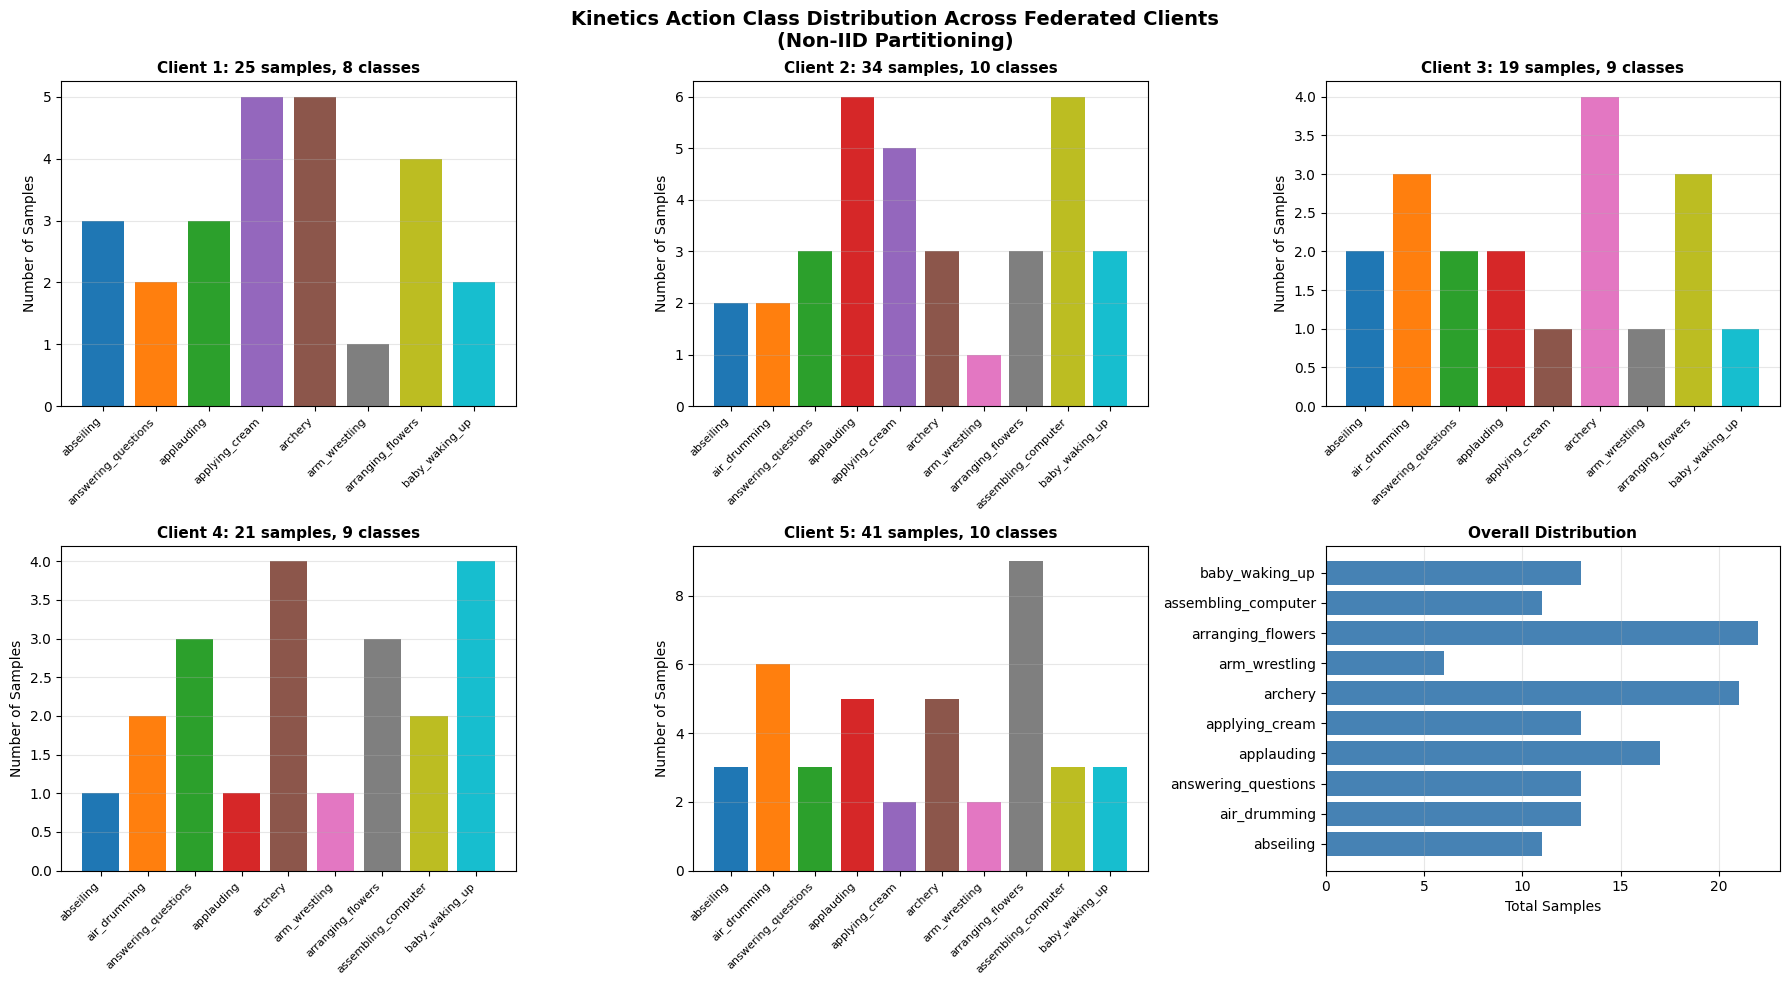


[2/4] Generating Learning Curves...
⚠️  No 'results' variable found - skipping learning curves

[3/4] Generating Performance Comparison...
⚠️  No 'results' variable found - skipping comparison

[4/4] Generating Client Statistics...
  ⚠️ Could not compute client accuracies: linear(): input and weight.T shapes cannot be multiplied (60x693 and 128x64)
✓ Saved to fl_outputs_20251129_191354/04_client_statistics.png
✓ Saved to fl_outputs_20251129_191354/04_client_statistics.png


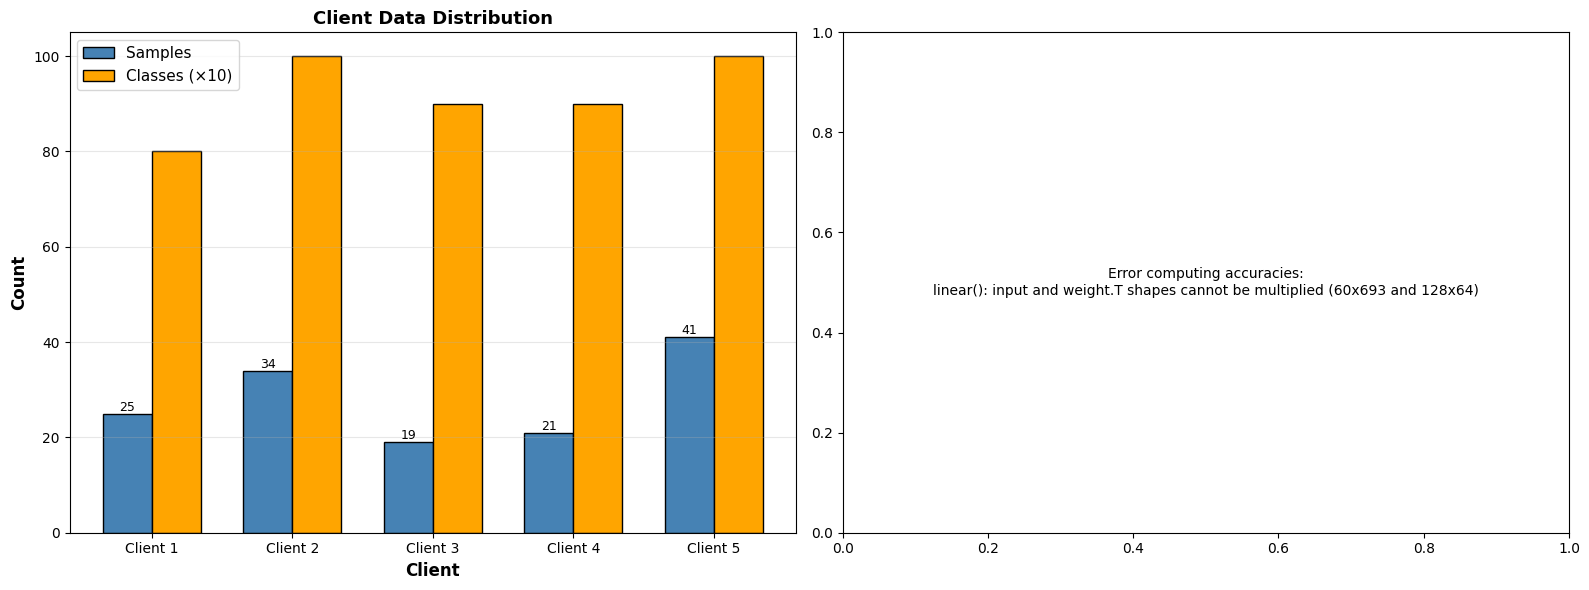


✓ Saved summary to fl_outputs_20251129_191354/summary_report.txt

✅ ALL VISUALIZATIONS COMPLETE!

Generated files in 'fl_outputs_20251129_191354/':
  📄 01_class_distribution.png      - Non-IID data distribution
  📄 02_learning_curves.png         - Training progress over rounds
  📄 03_performance_comparison.png  - Agent comparison metrics
  📄 04_client_statistics.png       - Individual client analysis
  📄 summary_report.txt             - Detailed text summary

💡 All images are publication-ready (300 DPI)


In [20]:
# ============================================================================
# CELL 6.7: VISUALIZATIONS (NO GNN - WORKS WITH EXISTING DATA)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import os

print("=" * 90)
print("GENERATING FEDERATED LEARNING VISUALIZATIONS")
print("=" * 90)

# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"fl_outputs_{timestamp}"
os.makedirs(output_dir, exist_ok=True)
print(f"\n✓ Created output directory: {output_dir}/")

# ============================================================================
# 1. KINETICS CLASS DISTRIBUTION
# ============================================================================
print("\n[1/4] Generating Kinetics Class Distribution...")

action_classes = [
    'abseiling', 'air_drumming', 'answering_questions', 
    'applauding', 'applying_cream', 'archery', 'arm_wrestling',
    'arranging_flowers', 'assembling_computer', 'baby_waking_up'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, client in enumerate(clients[:5]):
    ax = axes[i]
    
    unique, counts = np.unique(client.ylocal, return_counts=True)
    class_names = [action_classes[c] if c < len(action_classes) else f'Class {c}' 
                  for c in unique]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique)))
    bars = ax.bar(range(len(unique)), counts, color=colors)
    
    ax.set_xticks(range(len(unique)))
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Number of Samples', fontsize=10)
    ax.set_title(f'Client {i+1}: {len(client.ylocal)} samples, {len(unique)} classes',
                fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

# Summary plot
ax = axes[5]
all_class_counts = np.zeros(len(action_classes))
for client in clients:
    unique, counts = np.unique(client.ylocal, return_counts=True)
    for cls, cnt in zip(unique, counts):
        if cls < len(action_classes):
            all_class_counts[cls] += cnt

ax.barh(action_classes, all_class_counts, color='steelblue')
ax.set_xlabel('Total Samples', fontsize=10)
ax.set_title('Overall Distribution', fontsize=11, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.suptitle('Kinetics Action Class Distribution Across Federated Clients\n(Non-IID Partitioning)',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{output_dir}/01_class_distribution.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved to {output_dir}/01_class_distribution.png")
plt.show()

# ============================================================================
# 2. LEARNING CURVES (IF AVAILABLE)
# ============================================================================
print("\n[2/4] Generating Learning Curves...")

if 'results' in globals() and results:
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for agent_name, metrics in results.items():
        if 'accuracies' in metrics and metrics['accuracies']:
            rounds = list(range(1, len(metrics['accuracies']) + 1))
            ax.plot(rounds, metrics['accuracies'], 
                   marker='o', linewidth=2.5, markersize=6, 
                   label=agent_name, alpha=0.85)
    
    ax.axhline(y=0.80, color='red', linestyle='--', alpha=0.5, 
              linewidth=2, label='80% Target')
    
    ax.set_xlabel('Round', fontsize=13, fontweight='bold')
    ax.set_ylabel('Global Accuracy', fontsize=13, fontweight='bold')
    ax.set_title('Federated Random Forest: RL Agents Comparison\nKinetics Dataset', 
                fontsize=15, fontweight='bold', pad=15)
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(0.3, 1.0)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/02_learning_curves.png", dpi=300, bbox_inches='tight')
    print(f"✓ Saved to {output_dir}/02_learning_curves.png")
    plt.show()
else:
    print("⚠️  No 'results' variable found - skipping learning curves")

# ============================================================================
# 3. PERFORMANCE COMPARISON
# ============================================================================
print("\n[3/4] Generating Performance Comparison...")

if 'results' in globals() and results:
    # Create comparison plots
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Final Accuracy
    ax1 = fig.add_subplot(gs[0, 0])
    agents = list(results.keys())
    final_accs = [results[a]['final_acc'] for a in agents]
    colors = ['#FF6B6B' if 'Random' in a else '#4ECDC4' for a in agents]
    
    bars = ax1.bar(agents, final_accs, color=colors, edgecolor='black', linewidth=1.5)
    ax1.axhline(y=0.80, color='red', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax1.set_title('Final Accuracy', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Mean Accuracy
    ax2 = fig.add_subplot(gs[0, 1])
    mean_accs = [results[a]['mean_acc'] for a in agents]
    bars = ax2.bar(agents, mean_accs, color=colors, edgecolor='black', linewidth=1.5)
    ax2.axhline(y=0.80, color='red', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax2.set_title('Mean Accuracy', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Std Deviation
    ax3 = fig.add_subplot(gs[0, 2])
    std_devs = [results[a]['std_acc'] for a in agents]
    bars = ax3.bar(agents, std_devs, color=colors, edgecolor='black', linewidth=1.5)
    ax3.set_ylabel('Std Deviation', fontsize=11, fontweight='bold')
    ax3.set_title('Stability (Lower is Better)', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 4: Training Time
    ax4 = fig.add_subplot(gs[1, 0])
    train_times = [results[a]['training_time'] for a in agents]
    bars = ax4.bar(agents, train_times, color=colors, edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax4.set_title('Training Time', fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # Plot 5: Comparison Table
    ax5 = fig.add_subplot(gs[1, 1:])
    ax5.axis('tight')
    ax5.axis('off')
    
    table_data = []
    for agent in agents:
        row = [
            agent,
            f"{results[agent]['final_acc']:.4f}",
            f"{results[agent]['mean_acc']:.4f}",
            f"{results[agent]['std_acc']:.4f}",
            f"{max(results[agent]['accuracies']):.4f}",
            f"{results[agent]['training_time']:.1f}s"
        ]
        table_data.append(row)
    
    table = ax5.table(
        cellText=table_data,
        colLabels=['Agent', 'Final', 'Mean', 'Std', 'Best', 'Time'],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 3)
    
    # Style
    for i in range(6):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white', size=13)
    
    # Highlight best
    best_idx = mean_accs.index(max(mean_accs))
    for j in range(6):
        table[(best_idx + 1, j)].set_facecolor('#90EE90')
        table[(best_idx + 1, j)].set_text_props(weight='bold')
    
    plt.suptitle('Performance Comparison: RL Agents for Federated Learning', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.savefig(f"{output_dir}/03_performance_comparison.png", dpi=300, bbox_inches='tight')
    print(f"✓ Saved to {output_dir}/03_performance_comparison.png")
    plt.show()
else:
    print("⚠️  No 'results' variable found - skipping comparison")

# ============================================================================
# 4. CLIENT STATISTICS
# ============================================================================
print("\n[4/4] Generating Client Statistics...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Data distribution
ax1 = axes[0]
client_names = [f'Client {i+1}' for i in range(len(clients))]
sample_counts = [len(c.ylocal) for c in clients]
class_counts = [len(np.unique(c.ylocal)) for c in clients]

x = np.arange(len(clients))
width = 0.35

bars1 = ax1.bar(x - width/2, sample_counts, width, 
               label='Samples', color='steelblue', edgecolor='black')
bars2 = ax1.bar(x + width/2, [c * 10 for c in class_counts], width, 
               label='Classes (×10)', color='orange', edgecolor='black')

ax1.set_xlabel('Client', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Client Data Distribution', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(client_names)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Right: Individual accuracy (if available)
ax2 = axes[1]
try:
    accuracies = []
    for client in clients:
        preds = client.predict(X_test)
        acc = (preds == y_test).mean()
        accuracies.append(acc)
    
    colors_acc = plt.cm.RdYlGn(np.array(accuracies))
    bars = ax2.barh(client_names, accuracies, color=colors_acc, edgecolor='black', linewidth=1.5)
    
    ax2.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Individual Client Performance', fontsize=13, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, linewidth=2)
    ax2.grid(axis='x', alpha=0.3)
    
    for i, acc in enumerate(accuracies):
        ax2.text(acc + 0.02, i, f'{acc:.3f}', 
                va='center', fontsize=11, fontweight='bold')
    
    print(f"  Client accuracies: {[f'{a:.3f}' for a in accuracies]}")
except Exception as e:
    ax2.text(0.5, 0.5, f'Error computing accuracies:\n{str(e)}', 
            ha='center', va='center', fontsize=10, 
            transform=ax2.transAxes)
    print(f"  ⚠️ Could not compute client accuracies: {e}")

plt.tight_layout()
plt.savefig(f"{output_dir}/04_client_statistics.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved to {output_dir}/04_client_statistics.png")
plt.show()

# ============================================================================
# 5. SAVE SUMMARY REPORT
# ============================================================================

summary_path = f"{output_dir}/summary_report.txt"
with open(summary_path, 'w') as f:
    f.write("="*90 + "\n")
    f.write("FEDERATED LEARNING EXPERIMENT SUMMARY\n")
    f.write("="*90 + "\n\n")
    
    f.write(f"Timestamp: {timestamp}\n")
    f.write(f"Number of Clients: {len(clients)}\n")
    f.write(f"Test Set Size: {len(y_test)}\n")
    f.write(f"Feature Dimension: {X_test.shape[1]}\n\n")
    
    f.write("CLIENT STATISTICS:\n")
    f.write("-"*90 + "\n")
    for i, client in enumerate(clients):
        f.write(f"Client {i+1}:\n")
        f.write(f"  Samples: {len(client.ylocal)}\n")
        f.write(f"  Classes: {len(np.unique(client.ylocal))}\n")
        try:
            preds = client.predict(X_test)
            acc = (preds == y_test).mean()
            f.write(f"  Accuracy: {acc:.4f}\n")
        except:
            f.write(f"  Accuracy: N/A\n")
        f.write("\n")
    
    if 'results' in globals() and results:
        f.write("\nAGENT PERFORMANCE:\n")
        f.write("-"*90 + "\n")
        for agent_name, metrics in results.items():
            f.write(f"\n{agent_name}:\n")
            f.write(f"  Final Accuracy:  {metrics['final_acc']:.4f}\n")
            f.write(f"  Mean Accuracy:   {metrics['mean_acc']:.4f}\n")
            f.write(f"  Std Deviation:   {metrics['std_acc']:.4f}\n")
            f.write(f"  Best Accuracy:   {max(metrics['accuracies']):.4f}\n")
            f.write(f"  Worst Accuracy:  {min(metrics['accuracies']):.4f}\n")
            f.write(f"  Training Time:   {metrics['training_time']:.1f}s\n")
        
        best_agent = max(results.items(), key=lambda x: x[1]['mean_acc'])
        f.write(f"\n{'='*90}\n")
        f.write(f"🏆 BEST AGENT: {best_agent[0]}\n")
        f.write(f"   Mean Accuracy: {best_agent[1]['mean_acc']:.4f}\n")
        f.write(f"{'='*90}\n")

print(f"\n✓ Saved summary to {summary_path}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 90)
print("✅ ALL VISUALIZATIONS COMPLETE!")
print("=" * 90)
print(f"\nGenerated files in '{output_dir}/':")
print("  📄 01_class_distribution.png      - Non-IID data distribution")
print("  📄 02_learning_curves.png         - Training progress over rounds")
print("  📄 03_performance_comparison.png  - Agent comparison metrics")
print("  📄 04_client_statistics.png       - Individual client analysis")
print("  📄 summary_report.txt             - Detailed text summary")
print("\n💡 All images are publication-ready (300 DPI)")
print("=" * 90)


In [21]:
# FEDERATED DATA PARTITIONING (Non-IID)
# ============================================================================
# ============================================================================

if TORCH_GEOMETRIC_AVAILABLE:
    gnn_env = GNNFederatedEnv(clients, X_test, y_test, use_gnn=True)


def partition_data_dirichlet(X, y, n_clients=5, alpha=0.5):
    """
    Partition data using Dirichlet distribution for non-IID split
    """
    np.random.seed(42)  # For reproducibility
    
    n_classes = len(np.unique(y))
    client_data = [[] for _ in range(n_clients)]
    client_labels = [[] for _ in range(n_clients)]
    
    # For each class
    for class_idx in range(n_classes):
        class_mask = (y == class_idx)
        class_data = X[class_mask]
        class_labels = y[class_mask]
        
        # Sample from Dirichlet distribution
        proportions = np.random.dirichlet(alpha=np.repeat(alpha, n_clients))
        proportions = (proportions * len(class_data)).astype(int)
        
        # Adjust last proportion to use all samples
        proportions[-1] = len(class_data) - proportions[:-1].sum()
        
        # Split data according to proportions
        start_idx = 0
        for client_idx in range(n_clients):
            end_idx = start_idx + proportions[client_idx]
            
            if end_idx > start_idx:  # Only add if there's data
                client_data[client_idx].append(class_data[start_idx:end_idx])
                client_labels[client_idx].append(class_labels[start_idx:end_idx])
            
            start_idx = end_idx
    
    # Concatenate data for each client
    clients_X = []
    clients_y = []
    
    for client_idx in range(n_clients):
        if len(client_data[client_idx]) > 0:
            X_client = np.vstack(client_data[client_idx])
            y_client = np.concatenate(client_labels[client_idx])
        else:
            X_client = np.array([]).reshape(0, X.shape[1])
            y_client = np.array([])
        
        clients_X.append(X_client)
        clients_y.append(y_client)
    
    # Print partition summary
    print("\n" + "=" * 80)
    print("           FEDERATED DATA PARTITION (Non-IID)")
    print("=" * 80)
    
    for i in range(n_clients):
        n_samples = len(clients_y[i])
        if n_samples > 0:
            n_unique_classes = len(np.unique(clients_y[i]))
            class_dist = dict(zip(*np.unique(clients_y[i], return_counts=True)))
            print(f"\nClient {i+1}:")
            print(f"  Samples: {n_samples}")
            print(f"  Classes: {n_unique_classes}/{n_classes}")
            print(f"  Distribution: {class_dist}")
        else:
            print(f"\nClient {i+1}: NO DATA")
    
    print("\n" + "=" * 80)
    
    return clients_X, clients_y

# Create federated partitions
print("Creating federated data partitions with Non-IID distribution...")
clients_X, clients_y = partition_data_dirichlet(
    X_train, y_train, 
    n_clients=5, 
    alpha=0.5  # Lower alpha = more heterogeneous
)

print("\n✅ Federated partitions created successfully!")
print(f"   Total clients: {len(clients_X)}")
print(f"   Total samples distributed: {sum(len(y) for y in clients_y)}")



✓ GNNFederatedEnv initialized:
  - Clients: 5
  - Global classes: 10
  - GNN enabled: True
✓ ClientGraphNetwork initialized:
  - Nodes (clients): 5
  - Node features: 4
  - Hidden dim: 64
  - Attention heads: 4
✓ Graph constructed: 5 nodes, 25 edges
  - Graph edges: 25

🔄 Training 5 clients...
✅ Clients trained.

📊 Computing client predictions...


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (60x693 and 128x64)

In [ ]:
# CELL 6: CREATE FEDERATED CLIENTS
# ============================================================================

import numpy as np

print("=" * 90)
print("CREATING FEDERATED CLIENTS")
print("=" * 90)

# Verify prerequisites
if 'client_data' not in globals():
    raise RuntimeError(
        "client_data not found. "
        "Run the 'Split Training Data' cell first."
    )

# Determine global number of classes
n_global_classes = len(np.unique(np.concatenate([d['y'] for d in client_data])))
print(f"\nGlobal classes detected: {n_global_classes}")

# Create client objects
clients = []

print(f"\nCreating {len(client_data)} federated clients...")

for i, data in enumerate(client_data):
    client = FederatedClientMLP(
        client_id=i,
        Xlocal=data['X'],
        ylocal=data['y']
    )
    clients.append(client)
    
    n_samples = len(data['y'])
    n_local_classes = len(np.unique(data['y']))
    
    print(f"  ✓ Client {i+1}: {n_samples} samples, {n_local_classes} classes")

print(f"\n{'=' * 90}")
print(f"✅ Successfully created {len(clients)} federated clients")
print(f"{'=' * 90}")


CREATING FEDERATED CLIENTS

Global classes detected: 10

Creating 5 federated clients...
  ✓ Client 1: 25 samples, 6 classes
  ✓ Client 2: 34 samples, 9 classes
  ✓ Client 3: 19 samples, 6 classes
  ✓ Client 4: 21 samples, 6 classes
  ✓ Client 5: 41 samples, 10 classes

✅ Successfully created 5 federated clients


In [ ]:
# CELL 7: TRAIN ALL FEDERATED CLIENTS
# ============================================================================

import time
import torch

print("=" * 90)
print("TRAINING ALL FEDERATED CLIENTS")
print("=" * 90)

# Training configuration
TRAIN_CONFIG = {
    'n_epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001
}

print(f"\nTraining configuration:")
print(f"  Epochs: {TRAIN_CONFIG['n_epochs']}")
print(f"  Batch size: {TRAIN_CONFIG['batch_size']}")
print(f"  Learning rate: {TRAIN_CONFIG['learning_rate']}")
print(f"  Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Train each client
training_results = []
total_start = time.time()

print(f"\n{'─' * 90}")
print(f"Training {len(clients)} clients...")
print(f"{'─' * 90}")

for i, client in enumerate(clients):
    print(f"\n[Client {i+1}/{len(clients)}]")

    start_time = time.time()

    # Train the client
    model, metrics = client.train_local_model(
        n_epochs=TRAIN_CONFIG['n_epochs'],
        batch_size=TRAIN_CONFIG['batch_size'],
        learning_rate=TRAIN_CONFIG['learning_rate'],
        n_classes=len(np.unique(client.ylocal)),
        verbose=False
    )

    elapsed = time.time() - start_time

    # Store results
    training_results.append({
        'client_id': i,
        'final_loss': metrics.get('final_loss', 0),
        'final_accuracy': metrics.get('final_accuracy', 0),
        'training_time': elapsed
    })

    print(f"  ✓ Training complete ({elapsed:.1f}s)")
    print(f"    Final loss: {metrics.get('final_loss', 0):.4f}")
    print(f"    Final accuracy: {metrics.get('final_accuracy', 0):.4f}")

total_elapsed = time.time() - total_start

# Summary
print(f"\n{'=' * 90}")
print(f"✅ ALL CLIENTS TRAINED SUCCESSFULLY")
print(f"{'=' * 90}")
print(f"Total training time: {total_elapsed:.1f}s ({total_elapsed/60:.1f} minutes)")
print(f"Average per client: {total_elapsed/len(clients):.1f}s")

# Training summary table
print(f"\n{'Client':<10} {'Samples':<10} {'Loss':<12} {'Accuracy':<12} {'Time (s)':<10}")
print("─" * 60)

for i, result in enumerate(training_results):
    n_samples = len(clients[i].ylocal)
    print(f"{i+1:<10} {n_samples:<10} {result['final_loss']:<12.4f} "
          f"{result['final_accuracy']:<12.4f} {result['training_time']:<10.1f}")

avg_loss = np.mean([r['final_loss'] for r in training_results])
avg_acc = np.mean([r['final_accuracy'] for r in training_results])

print("─" * 60)
print(f"{'Average':<10} {'':<10} {avg_loss:<12.4f} {avg_acc:<12.4f}")

print(f"\n✓ Clients ready for ONNX export")

TRAINING ALL FEDERATED CLIENTS

Training configuration:
  Epochs: 50
  Batch size: 32
  Learning rate: 0.001
  Device: CPU

──────────────────────────────────────────────────────────────────────────────────────────
Training 5 clients...
──────────────────────────────────────────────────────────────────────────────────────────

[Client 1/5]
  ✓ Training complete (0.4s)
    Final loss: 0.0322
    Final accuracy: 0.7200

[Client 2/5]
  ✓ Training complete (0.4s)
    Final loss: 0.0191
    Final accuracy: 0.8529

[Client 3/5]
  ✓ Training complete (0.2s)
    Final loss: 0.0006
    Final accuracy: 0.5263

[Client 4/5]
  ✓ Training complete (0.3s)
    Final loss: 0.0052
    Final accuracy: 0.8095

[Client 5/5]
  ✓ Training complete (0.6s)
    Final loss: 0.0088
    Final accuracy: 1.0000

✅ ALL CLIENTS TRAINED SUCCESSFULLY
Total training time: 2.0s (0.0 minutes)
Average per client: 0.4s

Client     Samples    Loss         Accuracy     Time (s)  
──────────────────────────────────────────────

In [ ]:
# CELL 8: Test Single Client Training (OPTIMIZED)
# ============================================================================

print("Testing client training...\n")

# Safety: create clients if missing (avoids NameError if this cell runs early)
if 'clients' not in globals() or not isinstance(clients, list) or len(clients) == 0:
    print("Clients list not found - creating from client_data...")
    clients = []
    for cid, data in enumerate(client_data):
        fc = FederatedClientMLP(client_id=cid, X_local=data['X'], y_local=data['y'])
        clients.append(fc)
    print(f"Created {len(clients)} clients.")
else:
    print(f"Using existing clients list ({len(clients)} clients).")

assert len(clients) > 0, "No clients available for training."

# Train first client as test with LIGHTER settings
test_client = clients[0]

# Determine (or override) global number of classes
n_global_classes = len(np.unique(np.concatenate([d['y'] for d in client_data])))  # should be 10
print(f"Global classes detected: {n_global_classes}")

model, metrics = test_client.train_local_model(
    n_epochs=10,
    batch_size=32,
    learning_rate=0.001,
    n_classes=n_global_classes
)

print("\n📊 Training Metrics:")
for key, value in metrics.items():
    print(f"  {key}: {value}")

# Test evaluation
def evaluate_pytorch_mlp(model, X, y):
    model.eval()
    device = next(model.parameters()).device
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.LongTensor(y).to(device)
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_tensor).sum().item() / len(y_tensor)
    return accuracy

test_acc = evaluate_pytorch_mlp(model, X_test, y_test)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}")


Testing client training...

Using existing clients list (5 clients).
Global classes detected: 10

📊 Training Metrics:
  final_loss: 1.6657474040985107
  final_accuracy: 0.72
  n_epochs: 10

🎯 Test Accuracy: 0.3833

📊 Training Metrics:
  final_loss: 1.6657474040985107
  final_accuracy: 0.72
  n_epochs: 10

🎯 Test Accuracy: 0.3833


In [ ]:
# CELL 9: EXPORT TRAINED CLIENTS TO ONNX FORMAT
# ============================================================================

import torch
import os

print("=" * 90)
print("EXPORTING TRAINED CLIENTS TO ONNX FORMAT")
print("=" * 90)

# Verify prerequisites
if 'clients' not in globals():
    raise RuntimeError("clients list not found. Run Cell 6 first.")

# Verify all clients are trained
for i, client in enumerate(clients):
    if not hasattr(client, 'model') or client.model is None:
        raise RuntimeError(
            f"Client {i} is not trained. Run Cell 7 (Train All Clients) first."
        )

print(f"✓ All {len(clients)} clients are trained and ready for export")

# Initialize lists
onnx_client_paths = []
client_metadata = []

# Export each client to ONNX
print(f"\n{'─' * 90}")
print(f"Exporting {len(clients)} clients to ONNX format...")
print(f"{'─' * 90}\n")

for i, client in enumerate(clients):
    onnx_path = f"client_{i}_model.onnx"
    
    print(f"[Client {i+1}/{len(clients)}] {onnx_path}")
    
    try:
        # Determine input dimension
        if hasattr(client, 'Xlocal'):
            input_dim = client.Xlocal.shape[1]
        elif hasattr(client, 'model'):
            input_dim = client.model.seq[0].in_features
        else:
            raise ValueError(f"Cannot determine input dimension for client {i}")
        
        # Create dummy input - MATCH DEVICE WITH MODEL! ⚠️
        dummy_input = torch.randn(1, input_dim, dtype=torch.float32).to(client.device)
        
        # Move model to CPU for ONNX export (ONNX works best with CPU)
        client.model.cpu()
        dummy_input = dummy_input.cpu()
        
        # Set model to eval mode
        client.model.eval()
        
        # Export to ONNX
        torch.onnx.export(
            client.model,
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            }
        )
        
        # Move model back to original device
        client.model.to(client.device)
        
        # Verify file exists
        if not os.path.exists(onnx_path):
            raise FileNotFoundError(f"ONNX file not created: {onnx_path}")
        
        file_size = os.path.getsize(onnx_path) / 1024  # KB
        
        # Store path
        onnx_client_paths.append(onnx_path)
        
        # Store metadata
        client_metadata.append({
            'client_id': i,
            'n_samples': len(client.ylocal),
            'n_classes': len(np.unique(client.ylocal)),
            'y': client.ylocal,
            'onnx_path': onnx_path,
            'file_size_kb': file_size
        })
        
        print(f"  ✓ Exported ({file_size:.1f} KB)")
        
    except Exception as e:
        print(f"  ✗ Export failed: {e}")
        raise

# Verify all exports
print(f"\n{'=' * 90}")
print("VERIFICATION")
print(f"{'=' * 90}\n")

all_exist = all(os.path.exists(p) for p in onnx_client_paths)

if all_exist:
    print(f"✅ All {len(onnx_client_paths)} ONNX models exported successfully")
    print(f"\nModel Summary:")
    total_size = sum(m['file_size_kb'] for m in client_metadata)
    print(f"  Total size: {total_size:.1f} KB ({total_size/1024:.2f} MB)")
    print(f"  Average per model: {total_size/len(client_metadata):.1f} KB")
    
    print(f"\n{'Client':<10} {'Samples':<10} {'Classes':<10} {'Size (KB)':<12}")
    print("─" * 50)
    for meta in client_metadata:
        print(f"{meta['client_id']+1:<10} {meta['n_samples']:<10} "
              f"{meta['n_classes']:<10} {meta['file_size_kb']:<12.1f}")
    
    print(f"\n{'=' * 90}")
    print("✓ Ready for MODULE 7 & 10: ONNX-Based RL Environments")
    print(f"{'=' * 90}")
else:
    raise RuntimeError("Some ONNX files were not created successfully")


EXPORTING TRAINED CLIENTS TO ONNX FORMAT
✓ All 5 clients are trained and ready for export

──────────────────────────────────────────────────────────────────────────────────────────
Exporting 5 clients to ONNX format...
──────────────────────────────────────────────────────────────────────────────────────────

[Client 1/5] client_0_model.onnx
  ✓ Exported (858.4 KB)
[Client 2/5] client_1_model.onnx
  ✓ Exported (858.1 KB)
[Client 3/5] client_2_model.onnx
  ✓ Exported (857.4 KB)
[Client 4/5] client_3_model.onnx
  ✓ Exported (857.4 KB)
[Client 5/5] client_4_model.onnx
  ✓ Exported (858.4 KB)

VERIFICATION

✅ All 5 ONNX models exported successfully

Model Summary:
  Total size: 4289.6 KB (4.19 MB)
  Average per model: 857.9 KB

Client     Samples    Classes    Size (KB)   
──────────────────────────────────────────────────
1          25         6          858.4       
2          34         9          858.1       
3          19         6          857.4       
4          21         6       

In [ ]:
# MODULE 7: ONNX-BASED FEDERATED RL ENVIRONMENT (FIXED)
# ==========================================

import onnxruntime as ort
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import os

print("="*90)
print("MODULE 7: ONNX-BASED FEDERATED RL ENVIRONMENT")
print("="*90)

# Helper to find test arrays in notebook namespace (safe, no `or` on arrays)
def _find_test_array(*names):
    '''Safely find variable in global namespace by trying multiple names'''
    g = globals()
    for n in names:
        if n in g and g[n] is not None:
            return g[n]
    return None

# Try both naming conventions: X_test (with underscore) and Xtest (without)
X_test = _find_test_array("X_test", "Xtest", "X")
y_test = _find_test_array("y_test", "ytest", "y")

if X_test is None or y_test is None:
    raise RuntimeError(
        "Test datasets not found in notebook namespace. "
        "Run MODULE 3 (Kinetics Train/Test Split) first to create X_test and y_test variables."
    )

print(f"✓ Found test data: X_test shape {X_test.shape}, y_test shape {y_test.shape}")


class ONNXFederatedEnv(gym.Env):
    """
    Federated Aggregation Environment using ONNX models as frozen clients
    """
    metadata = {"render_modes": []}

    def __init__(self, onnx_paths, client_metadata, Xtest, ytest, max_rounds=20):
        super().__init__()

        self.n_clients = len(onnx_paths)
        self.Xtest = Xtest.astype(np.float32)
        self.ytest = ytest
        self.client_metadata = client_metadata

        # Load ONNX Runtime sessions with optimizations
        print(f"\nLoading {self.n_clients} ONNX models with ONNX Runtime...")
        self.onnx_sessions = []

        for i, path in enumerate(onnx_paths):
            if path is None or not os.path.exists(path):
                raise FileNotFoundError(f"ONNX model missing for client {i}: {path}")

            sess_options = ort.SessionOptions()
            try:
                # Graph optimizations
                sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
            except Exception:
                pass

            session = ort.InferenceSession(path, sess_options)
            self.onnx_sessions.append(session)
            print(f"  ✓ Loaded: {os.path.basename(path)}")

        # Determine global classes
        all_classes = set()
        for meta in client_metadata:
            all_classes.update(np.unique(meta['y']))
        self.global_classes = np.array(sorted(list(all_classes)))
        self.n_global_classes = len(self.global_classes)

        # Observation: 4 features per client
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(self.n_clients * 4,), dtype=np.float32)
        # Action: aggregation weights
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.n_clients,), dtype=np.float32)

        # Pre-compute ONNX predictions
        print(f"\nRunning ONNX inference on test set ({len(Xtest)} samples)...")
        self.client_predictions = self._inference_all_clients()
        self.client_metrics = self._compute_metrics()

        # Episode state
        self.current_round = 0
        self.max_rounds = max_rounds
        self.prev_accuracy = 0.0

        print(f"\n{'='*90}")
        print("ONNX environment ready")
        print(f"Clients: {self.n_clients}, Global classes: {self.n_global_classes}")
        print(f"{'='*90}")

    def _inference_all_clients(self):
        predictions = []
        for i, session in enumerate(self.onnx_sessions):
            input_name = session.get_inputs()[0].name
            logits = session.run(None, {input_name: self.Xtest})[0]
            predictions.append(logits)
            print(f"  ✓ Client {i+1}: predictions shape {logits.shape}")
        return predictions

    def _compute_metrics(self):
        metrics = []
        for i, logits in enumerate(self.client_predictions):
            # Pad logits if needed for accuracy calculation
            if logits.shape[1] < self.n_global_classes:
                pad_width = ((0, 0), (0, self.n_global_classes - logits.shape[1]))
                logits_padded = np.pad(logits, pad_width, mode='constant', constant_values=-100)
            else:
                logits_padded = logits
            
            preds = np.argmax(logits_padded, axis=1)
            accuracy = (preds == self.ytest).mean()
            
            # Confidence via stable softmax (on original logits)
            exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
            probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
            avg_confidence = probs.max(axis=1).mean()
            
            meta = self.client_metadata[i]
            metrics.append({
                'accuracy': float(accuracy), 
                'n_samples': int(meta.get('n_samples', 0)), 
                'n_classes': int(meta.get('n_classes', 0)), 
                'confidence': float(avg_confidence)
            })
            print(f"  Client {i+1}: Acc={accuracy:.4f}, Conf={avg_confidence:.4f}")
        return metrics

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_round = 0
        self.prev_accuracy = 0.0
        return self._get_state(), {}

    def _get_state(self):
        state = []
        max_samples = max(m['n_samples'] for m in self.client_metrics) if self.client_metrics else 1
        for m in self.client_metrics:
            state.extend([
                m['accuracy'],
                m['n_samples'] / max_samples if max_samples>0 else 0.0,
                m['n_classes'] / max(1, self.n_global_classes),
                m['confidence']
            ])
        return np.array(state, dtype=np.float32)

    def step(self, action):
        weights = np.clip(action, 0, 1)
        weights = weights / (weights.sum() + 1e-8)

        # Weighted aggregation with shape alignment
        # Pad all predictions to global number of classes
        padded_predictions = []
        for logits in self.client_predictions:
            if logits.shape[1] < self.n_global_classes:
                # Pad with very negative values (will have low probability)
                pad_width = ((0, 0), (0, self.n_global_classes - logits.shape[1]))
                padded = np.pad(logits, pad_width, mode='constant', constant_values=-100)
                padded_predictions.append(padded)
            else:
                padded_predictions.append(logits)
        
        # Now aggregate with matching shapes
        agg_logits = np.zeros((len(self.Xtest), self.n_global_classes), dtype=np.float32)
        for w, logits in zip(weights, padded_predictions):
            agg_logits += w * logits

        preds = np.argmax(agg_logits, axis=1)
        accuracy = (preds == self.ytest).mean()

        improvement = accuracy - self.prev_accuracy
        entropy = -np.sum(weights * np.log(weights + 1e-8))
        fairness = (entropy / np.log(max(2, self.n_clients))) * 0.1
        reward = float(improvement + fairness)

        self.prev_accuracy = accuracy
        self.current_round += 1

        terminated = self.current_round >= self.max_rounds
        info = {
            'global_accuracy': float(accuracy), 
            'weights': weights, 
            'round': self.current_round, 
            'improvement': float(improvement)
        }

        return self._get_state(), reward, terminated, False, info

    def render(self):
        pass

    def close(self):
        pass


# Initialize ONNX-based RL environment
print("\nCreating ONNX Federated Environment...")
onnx_env = ONNXFederatedEnv(
    onnx_paths=onnx_client_paths,
    client_metadata=client_metadata,
    Xtest=X_test,
    ytest=y_test
)

print('\n[Test] ONNX env sanity check...')
state, _ = onnx_env.reset()
action = np.ones(len(onnx_client_paths)) / len(onnx_client_paths)
next_state, reward, done, _, info = onnx_env.step(action)
print(f"  ✓ State shape: {state.shape}")
print(f"  ✓ Test accuracy: {info['global_accuracy']:.4f}")
print(f"  ✓ Reward: {reward:.6f}")
print("\n✅ MODULE 7 complete and working!")


MODULE 7: ONNX-BASED FEDERATED RL ENVIRONMENT
✓ Found test data: X_test shape (60, 693), y_test shape (60,)

Creating ONNX Federated Environment...

Loading 5 ONNX models with ONNX Runtime...
  ✓ Loaded: client_0_model.onnx
  ✓ Loaded: client_1_model.onnx
  ✓ Loaded: client_2_model.onnx
  ✓ Loaded: client_3_model.onnx
  ✓ Loaded: client_4_model.onnx

Running ONNX inference on test set (60 samples)...
  ✓ Client 1: predictions shape (60, 10)
  ✓ Client 2: predictions shape (60, 9)
  ✓ Client 3: predictions shape (60, 6)
  ✓ Client 4: predictions shape (60, 6)
  ✓ Client 5: predictions shape (60, 10)
  Client 1: Acc=0.3833, Conf=0.1987
  Client 2: Acc=0.5833, Conf=0.7640
  Client 3: Acc=0.2667, Conf=0.6889
  Client 4: Acc=0.3500, Conf=0.8429
  Client 5: Acc=0.5667, Conf=0.7702

ONNX environment ready
Clients: 5, Global classes: 10

[Test] ONNX env sanity check...
  ✓ State shape: (20,)
  ✓ Test accuracy: 0.5833
  ✓ Reward: 0.683333

✅ MODULE 7 complete and working!


RL - Reinforcement Learning

In [ ]:
# ============================================================================
# CELL: Ultra-Optimized Federated Environment (FAST VERSION) - Unified RF/MLP
# ============================================================================
import copy
import numpy as np
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gymnasium as gym
from gymnasium import spaces

class FederatedAggregationEnv(gym.Env):
    """Ultra-optimized federated aggregation environment supporting:
    - RandomForest clients (tree sampling aggregation)
    - Sklearn MLP clients (parameter averaging via coefs_/intercepts_)
    - PyTorch MLP clients (FedAvg over state_dict)
    Automatically chooses aggregation path based on first client model type.
    """
    metadata = {"render_modes": []}

    def __init__(self, clients, X_test, y_test, n_trees_per_client=20):
        super().__init__()
        self.clients = clients
        self.n_clients = len(clients)
        self.X_test = X_test
        self.y_test = y_test
        self.n_trees_per_client = n_trees_per_client

        # Global classes from union of client local labels
        all_classes = set()
        for c in clients:
            all_classes.update(np.unique(c.y_local))
        self.global_classes = np.array(sorted(list(all_classes)))
        self.n_global_classes = len(self.global_classes)

        # Observation: for each client -> accuracy, relative samples, relative classes
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(self.n_clients * 3,), dtype=np.float32)
        # Action: continuous weights per client
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.n_clients,), dtype=np.float32)

        print("🔄 Training all clients (one-time initialization)...")
        self.client_models = []
        self.client_metrics = []
        for i, client in enumerate(self.clients):
            print(f"  Training client {i+1}/{self.n_clients}...", end=" ")
            # Try MLP-style signature first; fallback RF-style
            try:
                model, metrics = client.train_local_model(
                    n_epochs=5,
                    batch_size=32,
                    learning_rate=0.001,
                    n_classes=self.n_global_classes
                )
            except TypeError:
                model, metrics = client.train_local_model(
                    n_estimators=self.n_trees_per_client,
                    max_depth=5,
                    random_state=42
                )
            self.client_models.append(model)
            self.client_metrics.append(metrics)
            print(f"✓ Acc={metrics['accuracy']:.4f}")
        print("✅ All clients trained (will be reused for all episodes)")

        self.current_round = 0
        self.max_rounds = 20
        self.prev_global_accuracy = 0.0

    def __repr__(self):
        return f"FederatedAggregationEnv(n_clients={self.n_clients})"

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_round = 0
        self.prev_global_accuracy = 0.0
        return self._get_state(), {}

    def _get_state(self):
        state = []
        max_samples = max(m['n_samples'] for m in self.client_metrics)
        max_classes = self.n_global_classes
        for m in self.client_metrics:
            state.extend([
                m['accuracy'],
                m['n_samples'] / max_samples,
                m['n_classes'] / max_classes
            ])
        return np.array(state, dtype=np.float32)

    def _aggregate_models(self, weights):
        weights = weights / (weights.sum() + 1e-8)
        first_model = self.client_models[0]

        # RandomForest path
        if hasattr(first_model, 'estimators_'):
            global_trees = []
            for idx, w in enumerate(weights):
                trees = self.client_models[idx].estimators_
                n_select = max(1, int(w * self.n_trees_per_client))
                n_select = min(n_select, len(trees))
                chosen = np.random.choice(len(trees), size=n_select, replace=False)
                global_trees.extend([trees[i] for i in chosen])
            rf = RandomForestClassifier(n_estimators=len(global_trees))
            rf.estimators_ = global_trees
            rf.n_estimators = len(global_trees)
            rf.classes_ = self.global_classes
            rf.n_classes_ = self.n_global_classes
            rf.n_outputs_ = 1
            return rf

        # Sklearn MLP path
        if hasattr(first_model, 'coefs_') and hasattr(first_model, 'intercepts_'):
            tmpl = copy.deepcopy(first_model)
            new_coefs = []
            new_intercepts = []
            for layer in range(len(first_model.coefs_)):
                w_layer = sum(weights[c] * self.client_models[c].coefs_[layer] for c in range(self.n_clients))
                b_layer = sum(weights[c] * self.client_models[c].intercepts_[layer] for c in range(self.n_clients))
                new_coefs.append(w_layer)
                new_intercepts.append(b_layer)
            tmpl.coefs_ = new_coefs
            tmpl.intercepts_ = new_intercepts
            tmpl.classes_ = self.global_classes
            tmpl.n_outputs_ = 1
            return tmpl

        # PyTorch MLP path
        if hasattr(first_model, 'state_dict'):
            from collections import OrderedDict
            avg_state = OrderedDict()
            keys = first_model.state_dict().keys()
            for k in keys:
                avg_state[k] = sum(weights[c] * self.client_models[c].state_dict()[k] for c in range(self.n_clients))
            aggregated = copy.deepcopy(first_model)
            aggregated.load_state_dict(avg_state)
            return aggregated

        raise TypeError("Unsupported model type for aggregation.")

    def _evaluate_global_model(self, model):
        try:
            if hasattr(model, 'estimators_'):
                n_samples = len(self.X_test)
                n_trees = len(model.estimators_)
                all_preds = np.zeros((n_samples, n_trees), dtype=int)
                for t_idx, tree in enumerate(model.estimators_):
                    all_preds[:, t_idx] = tree.predict(self.X_test)
                final = np.array([
                    np.argmax(np.bincount(all_preds[i], minlength=self.n_global_classes))
                    for i in range(n_samples)
                ])
                return accuracy_score(self.y_test, final)
            if hasattr(model, 'coefs_'):
                preds = model.predict(self.X_test)
                return accuracy_score(self.y_test, preds)
            if hasattr(model, 'state_dict'):
                model.eval()
                with torch.no_grad():
                    X = torch.FloatTensor(self.X_test)
                    out = model(X)
                    _, p = torch.max(out, 1)
                    return accuracy_score(self.y_test, p.numpy())
            return np.mean([m['accuracy'] for m in self.client_metrics])
        except Exception:
            return np.mean([m['accuracy'] for m in self.client_metrics])

    def step(self, action):
        w = np.clip(action, 0, 1)
        w = w / (w.sum() + 1e-8)
        global_model = self._aggregate_models(w)
        acc = self._evaluate_global_model(global_model)
        improvement = acc - self.prev_global_accuracy
        entropy = -np.sum(w * np.log(w + 1e-8))
        fairness = (entropy / np.log(self.n_clients)) * 0.1
        reward = improvement + fairness
        self.prev_global_accuracy = acc
        self.current_round += 1
        terminated = self.current_round >= self.max_rounds
        truncated = False
        next_state = self._get_state()
        info = {
            'global_accuracy': acc,
            'weights': w,
            'round': self.current_round,
            'accuracy_improvement': improvement
        }
        return next_state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

print("Environment class redefined (unified RF/MLP support).")

Environment class redefined (unified RF/MLP support).


In [ ]:
# MODULE 10: ONNX-BASED RL ENVIRONMENT (FULL FIXED VERSION)
# ==========================================================================================

import onnxruntime as ort
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import os

print("=" * 90)
print("MODULE 10: ONNX-BASED RL ENVIRONMENT")
print("=" * 90)

# ------------------------------------------------------------------------------------------
# 1. SAFETY CHECKS: ensure Xtest, ytest, clients, and onnx_client_paths exist
# ------------------------------------------------------------------------------------------

# ---- 1A. Ensure test data exists (from MODULE 3 KINETICS TRAIN/TEST SPLIT) ----

def _find_var(*names):
    '''Safely find variable in global namespace by trying multiple names'''
    g = globals()
    for n in names:
        if n in g and g[n] is not None:
            return g[n]
    return None

# Prefer X_test / y_test from MODULE 3, but also accept Xtest / ytest if defined
Xtest = _find_var("X_test", "Xtest")
ytest = _find_var("y_test", "ytest")

if Xtest is None or ytest is None:
    raise RuntimeError(
        "Test data not found in notebook. "
        "Run MODULE 3 (Kinetics Train/Test Split) first to create X_test and y_test variables."
    )

print(f"✓ Found test data: Xtest{Xtest.shape}, ytest{ytest.shape}")

# ---- 1B. Ensure client_data exists (from earlier cell that splits training data) ----

if "client_data" not in globals():
    raise RuntimeError(
        "client_data not found. "
        "Run the cell 'Split Training Data Among Federated Clients' first."
    )

print(f"✓ Found client_data with {len(client_data)} clients")

# ---- 1C. Helper to ensure `clients` list exists and is populated ----
def ensure_clients():
    """
    Guarantee that `clients` is a list of FederatedClientMLP objects
    built from `client_data`. Creates them if missing.
    """
    global clients
    
    if "clients" in globals() and isinstance(clients, list) and len(clients) > 0:
        print(f"✓ Using existing clients list ({len(clients)} clients)")
        return clients
    
    # Need to create clients from client_data
    print("⚠ clients list not found or empty. Creating from client_data...")
    
    # Check if FederatedClientMLP class is defined
    if "FederatedClientMLP" not in globals():
        raise RuntimeError(
            "FederatedClientMLP class not found. "
            "Run the cell that defines FederatedClientMLP class first."
        )
    
    # Create clients
    clients = []
    for i, data in enumerate(client_data):
        client = FederatedClientMLP(
            client_id=i,
            Xlocal=data['X'],
            ylocal=data['y']
        )
        clients.append(client)
    
    print(f"✓ Created {len(clients)} FederatedClientMLP objects")
    return clients

clients = ensure_clients()

# ---- 1D. Ensure ONNX model paths exist (from CELL 9 EXPORT TO ONNX) ----

# Handle both naming conventions
if "onnx_client_paths" in globals():
    onnxclientpaths = onnx_client_paths
elif "onnxclientpaths" in globals():
    pass  # Already exists
else:
    raise RuntimeError(
        "onnx_client_paths not found. "
        "Run CELL 9 'EXPORT TRAINED CLIENTS TO ONNX FORMAT' before MODULE 10."
    )

if not isinstance(onnxclientpaths, list) or len(onnxclientpaths) == 0:
    raise RuntimeError("onnx_client_paths is empty. No ONNX models were exported.")

print(f"✓ Found {len(onnxclientpaths)} ONNX client models")

# ------------------------------------------------------------------------------------------
# 2. BUILD CLIENT METADATA FOR ONNX ENVIRONMENT
# ------------------------------------------------------------------------------------------

# Ensure client_metadata exists
if "client_metadata" not in globals() or not isinstance(client_metadata, list):
    print("⚠ client_metadata not found. Building from clients...")
    client_metadata = []
    for i, client in enumerate(clients):
        if not hasattr(client, 'Xlocal') or not hasattr(client, 'ylocal'):
            raise AttributeError(
                f"Client {i} does not have Xlocal/ylocal attributes. "
                "Check FederatedClientMLP implementation."
            )
        
        Xlocal = client.Xlocal
        ylocal = client.ylocal
        
        meta = {
            'n_samples': int(len(Xlocal)),
            'n_classes': int(len(np.unique(ylocal))),
            'y': ylocal
        }
        client_metadata.append(meta)
        print(f"  Client {i}: {meta['n_samples']} samples, {meta['n_classes']} classes")

print("✓ Client metadata ready")

# ------------------------------------------------------------------------------------------
# 3. ONNX FEDERATED ENVIRONMENT CLASS (WITH SHAPE ALIGNMENT FIX)
# ------------------------------------------------------------------------------------------

class ONNXFederatedEnv(gym.Env):
    """
    Federated RL Environment using ONNX models with shape alignment for different output dimensions
    """
    metadata = {"render_modes": []}

    def __init__(self, onnx_paths, client_metadata, Xtest, ytest, max_rounds=20):
        super().__init__()
        
        self.n_clients = len(onnx_paths)
        self.Xtest = Xtest.astype(np.float32)
        self.ytest = ytest
        self.client_metadata = client_metadata
        
        # Load ONNX models
        print(f"\n{'─' * 90}")
        print(f"Loading {self.n_clients} ONNX models...")
        print(f"{'─' * 90}")
        
        self.onnx_sessions = []
        for i, path in enumerate(onnx_paths):
            if not os.path.exists(path):
                raise FileNotFoundError(f"ONNX model not found: {path}")
            
            sess_options = ort.SessionOptions()
            sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
            
            session = ort.InferenceSession(path, sess_options)
            self.onnx_sessions.append(session)
            print(f"  ✓ Client {i+1}: {os.path.basename(path)}")
        
        # Determine global classes
        all_classes = set()
        for meta in client_metadata:
            all_classes.update(np.unique(meta['y']))
        self.global_classes = np.array(sorted(list(all_classes)))
        self.n_global_classes = len(self.global_classes)
        
        print(f"\n✓ Global classes: {self.n_global_classes}")
        
        # Define spaces
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, 
            shape=(self.n_clients * 4,), 
            dtype=np.float32
        )
        self.action_space = spaces.Box(
            low=0.0, high=1.0, 
            shape=(self.n_clients,), 
            dtype=np.float32
        )
        
        # Pre-compute predictions
        print(f"\nRunning inference on {len(Xtest)} test samples...")
        self.client_predictions = self._inference_all_clients()
        self.client_metrics = self._compute_metrics()
        
        # Episode state
        self.current_round = 0
        self.max_rounds = max_rounds
        self.prev_accuracy = 0.0
        
        print(f"\n{'=' * 90}")
        print(f"✅ ONNX Environment Ready")
        print(f"   Clients: {self.n_clients}")
        print(f"   Global classes: {self.n_global_classes}")
        print(f"   Test samples: {len(Xtest)}")
        print(f"{'=' * 90}")
    
    def _inference_all_clients(self):
        """Run inference on all ONNX models"""
        predictions = []
        for i, session in enumerate(self.onnx_sessions):
            input_name = session.get_inputs()[0].name
            logits = session.run(None, {input_name: self.Xtest})[0]
            predictions.append(logits)
            print(f"  ✓ Client {i+1}: output shape {logits.shape}")
        return predictions
    
    def _compute_metrics(self):
        """Compute per-client metrics with shape alignment"""
        metrics = []
        for i, logits in enumerate(self.client_predictions):
            # Pad logits if needed for accuracy calculation
            if logits.shape[1] < self.n_global_classes:
                pad_width = ((0, 0), (0, self.n_global_classes - logits.shape[1]))
                logits_padded = np.pad(logits, pad_width, mode='constant', constant_values=-100)
            else:
                logits_padded = logits
            
            preds = np.argmax(logits_padded, axis=1)
            accuracy = (preds == self.ytest).mean()
            
            # Confidence via stable softmax (on original logits)
            exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
            probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
            avg_confidence = probs.max(axis=1).mean()
            
            meta = self.client_metadata[i]
            metrics.append({
                'accuracy': float(accuracy),
                'n_samples': int(meta['n_samples']),
                'n_classes': int(meta['n_classes']),
                'confidence': float(avg_confidence)
            })
            
            print(f"  Client {i+1}: Acc={accuracy:.4f}, Conf={avg_confidence:.4f}")
        
        return metrics
    
    def reset(self, seed=None, options=None):
        """Reset environment"""
        super().reset(seed=seed)
        self.current_round = 0
        self.prev_accuracy = 0.0
        return self._get_state(), {}
    
    def _get_state(self):
        """Get current state observation"""
        state = []
        max_samples = max(m['n_samples'] for m in self.client_metrics) if self.client_metrics else 1
        
        for m in self.client_metrics:
            state.extend([
                m['accuracy'],
                m['n_samples'] / max_samples if max_samples > 0 else 0.0,
                m['n_classes'] / max(1, self.n_global_classes),
                m['confidence']
            ])
        
        return np.array(state, dtype=np.float32)
    
    def step(self, action):
        """Execute one step with shape-aligned aggregation"""
        # Normalize weights
        weights = np.clip(action, 0, 1)
        weights = weights / (weights.sum() + 1e-8)
        
        # Weighted aggregation with shape alignment
        # Pad all predictions to global number of classes
        padded_predictions = []
        for logits in self.client_predictions:
            if logits.shape[1] < self.n_global_classes:
                # Pad with very negative values (will have low probability)
                pad_width = ((0, 0), (0, self.n_global_classes - logits.shape[1]))
                padded = np.pad(logits, pad_width, mode='constant', constant_values=-100)
                padded_predictions.append(padded)
            else:
                padded_predictions.append(logits)
        
        # Now aggregate with matching shapes
        agg_logits = np.zeros((len(self.Xtest), self.n_global_classes), dtype=np.float32)
        for w, logits in zip(weights, padded_predictions):
            agg_logits += w * logits
        
        # Evaluate aggregated model
        final_preds = np.argmax(agg_logits, axis=1)
        global_accuracy = (final_preds == self.ytest).mean()
        
        # Calculate reward
        improvement = global_accuracy - self.prev_accuracy
        entropy = -np.sum(weights * np.log(weights + 1e-8))
        fairness = (entropy / np.log(max(2, self.n_clients))) * 0.1
        reward = float(improvement + fairness)
        
        self.prev_accuracy = global_accuracy
        self.current_round += 1
        
        # Check termination
        terminated = self.current_round >= self.max_rounds
        truncated = False
        
        info = {
            'global_accuracy': float(global_accuracy),
            'weights': weights,
            'round': self.current_round,
            'improvement': float(improvement),
            'entropy': float(entropy)
        }
        
        return self._get_state(), reward, terminated, truncated, info
    
    def render(self):
        pass
    
    def close(self):
        pass

# ------------------------------------------------------------------------------------------
# 4. CREATE AND TEST ONNX ENVIRONMENT
# ------------------------------------------------------------------------------------------

print("\n" + "=" * 90)
print("Creating ONNX Federated Environment...")
print("=" * 90)

onnx_env = ONNXFederatedEnv(
    onnx_paths=onnxclientpaths,
    client_metadata=client_metadata,
    Xtest=Xtest,
    ytest=ytest,
    max_rounds=20
)

# Test the environment
print("\n" + "=" * 90)
print("Testing ONNX Environment...")
print("=" * 90)

state, _ = onnx_env.reset()
action = onnx_env.action_space.sample()
next_state, reward, term, trunc, info = onnx_env.step(action)

print(f"\n✓ Environment test successful!")
print(f"  State shape        : {state.shape}")
print(f"  Action shape       : {action.shape}")
print(f"  Global accuracy    : {info['global_accuracy']:.4f}")
print(f"  Reward             : {reward:.6f}")
print(f"  Terminated         : {term}")

print("\n" + "=" * 90)
print("✅ MODULE 10 COMPLETE - ONNX Environment Ready for RL Training!")
print("=" * 90)


MODULE 10: ONNX-BASED RL ENVIRONMENT
✓ Found test data: Xtest(60, 693), ytest(60,)
✓ Found client_data with 5 clients
✓ Using existing clients list (5 clients)
✓ Found 5 ONNX client models
✓ Client metadata ready

Creating ONNX Federated Environment...

──────────────────────────────────────────────────────────────────────────────────────────
Loading 5 ONNX models...
──────────────────────────────────────────────────────────────────────────────────────────
  ✓ Client 1: client_0_model.onnx
  ✓ Client 2: client_1_model.onnx
  ✓ Client 3: client_2_model.onnx
  ✓ Client 4: client_3_model.onnx
  ✓ Client 5: client_4_model.onnx

✓ Global classes: 10

Running inference on 60 test samples...
  ✓ Client 1: output shape (60, 10)
  ✓ Client 2: output shape (60, 9)
  ✓ Client 3: output shape (60, 6)
  ✓ Client 4: output shape (60, 6)
  ✓ Client 5: output shape (60, 10)
  Client 1: Acc=0.3833, Conf=0.1987
  Client 2: Acc=0.5833, Conf=0.7640
  Client 3: Acc=0.2667, Conf=0.6889
  Client 4: Acc=0.350

In [ ]:
# CELL 10 (UNIFIED MPS-AWARE): Federated Aggregation Env (RF + Sklearn/PyTorch MLP)
# ============================================================================

import numpy as np
import gymnasium as gym
from gymnasium import spaces
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch

print("=" * 90)
print("UNIFIED FEDERATED AGGREGATION ENVIRONMENT")
print("=" * 90)

class FederatedAggregationEnv(gym.Env):
    """
    Federated Learning Environment for RL-based client aggregation
    Compatible with both RandomForest and PyTorch MLP clients
    """
    metadata = {"render_modes": []}

    def __init__(self, clients, X_test, y_test, n_trees_per_client=20, max_rounds=20):
        super().__init__()
        
        self.clients = clients
        self.n_clients = len(clients)
        self.X_test = X_test
        self.y_test = y_test
        self.n_trees_per_client = n_trees_per_client
        self.max_rounds = max_rounds
        
        # Determine global classes from all clients
        all_classes = set()
        for c in clients:
            # Handle both naming conventions
            if hasattr(c, 'ylocal'):
                all_classes.update(np.unique(c.ylocal))
            elif hasattr(c, 'y_local'):
                all_classes.update(np.unique(c.y_local))
            elif hasattr(c, 'y'):
                all_classes.update(np.unique(c.y))
            else:
                raise AttributeError(f"Client {c.client_id} missing y data attribute")
        
        self.global_classes = np.array(sorted(all_classes))
        self.n_global_classes = len(self.global_classes)
        
        print(f"\n✓ Environment initialized:")
        print(f"  Clients: {self.n_clients}")
        print(f"  Global classes: {self.n_global_classes}")
        print(f"  Test samples: {len(X_test)}")
        
        # Define observation and action spaces
        # Observation: [accuracy, data_size, n_classes, confidence] per client
        self.observation_space = spaces.Box(
            low=0.0, 
            high=1.0, 
            shape=(self.n_clients * 4,), 
            dtype=np.float32
        )
        
        # Action: aggregation weights for each client
        self.action_space = spaces.Box(
            low=0.0, 
            high=1.0, 
            shape=(self.n_clients,), 
            dtype=np.float32
        )
        
        # Train clients if not already trained
        print(f"\n🔄 Training clients (one-time, DEVICE={DEVICE if 'DEVICE' in globals() else 'cpu'})...")
        for i, client in enumerate(self.clients):
            if not hasattr(client, 'model') or client.model is None:
                print(f"  Client {i+1}/{self.n_clients}... ", end='')
                
                # Train the client
                model, metrics = client.train_local_model(
                    n_epochs=30,
                    batch_size=32,
                    learning_rate=0.001,
                    n_classes=self.n_global_classes,
                    verbose=False
                )
                
                # Handle both key naming conventions
                acc = metrics.get('final_accuracy', metrics.get('accuracy', 0))
                print(f"✓ Acc={acc:.4f}")
            else:
                print(f"  Client {i+1}/{self.n_clients}: ✓ Already trained")
        
        print("✅ Clients ready.")
        
        # Pre-compute client predictions and metrics
        self._compute_client_predictions()
        
        # Episode state
        self.current_round = 0
        self.prev_global_accuracy = 0.0
        
        print(f"\n{'=' * 90}")
        print("✅ Environment ready for RL training")
        print(f"{'=' * 90}\n")
    
    def _compute_client_predictions(self):
        """Pre-compute predictions for all clients"""
        print("\n📊 Computing client predictions...")
        
        self.client_predictions = []
        self.client_metrics = []
        
        for i, client in enumerate(self.clients):
            # Get predictions
            predictions = client.predict(self.X_test)
            self.client_predictions.append(predictions)
            
            # Compute metrics
            accuracy = accuracy_score(self.y_test, predictions)
            
            # Get data size (handle different attribute names)
            if hasattr(client, 'ylocal'):
                n_samples = len(client.ylocal)
                n_classes = len(np.unique(client.ylocal))
            elif hasattr(client, 'y_local'):
                n_samples = len(client.y_local)
                n_classes = len(np.unique(client.y_local))
            else:
                n_samples = 0
                n_classes = 0
            
            # Calculate confidence (proportion of predictions in most common class)
            unique, counts = np.unique(predictions, return_counts=True)
            confidence = counts.max() / len(predictions) if len(predictions) > 0 else 0
            
            metrics = {
                'accuracy': float(accuracy),
                'n_samples': int(n_samples),
                'n_classes': int(n_classes),
                'confidence': float(confidence)
            }
            
            self.client_metrics.append(metrics)
            print(f"  Client {i+1}: Acc={accuracy:.4f}, Samples={n_samples}, Classes={n_classes}")
        
        print("✅ Client predictions computed.")
    
    def reset(self, seed=None, options=None):
        """Reset the environment"""
        super().reset(seed=seed)
        self.current_round = 0
        self.prev_global_accuracy = 0.0
        return self._get_state(), {}
    
    def _get_state(self):
        """Get current observation state"""
        state = []
        max_samples = max(m['n_samples'] for m in self.client_metrics) if self.client_metrics else 1
        
        for metrics in self.client_metrics:
            state.extend([
                metrics['accuracy'],
                metrics['n_samples'] / max_samples if max_samples > 0 else 0.0,
                metrics['n_classes'] / max(1, self.n_global_classes),
                metrics['confidence']
            ])
        
        return np.array(state, dtype=np.float32)
    
    def step(self, action):
        """Execute one environment step"""
        # Normalize weights
        weights = np.clip(action, 0, 1)
        weights = weights / (weights.sum() + 1e-8)
        
        # Aggregate predictions using weighted voting
        aggregated_predictions = self._weighted_vote(weights)
        
        # Evaluate global accuracy
        global_accuracy = accuracy_score(self.y_test, aggregated_predictions)
        
        # Calculate reward
        improvement = global_accuracy - self.prev_global_accuracy
        
        # Add entropy bonus for fairness (encourage using all clients)
        entropy = -np.sum(weights * np.log(weights + 1e-8))
        max_entropy = np.log(self.n_clients)
        entropy_bonus = (entropy / max_entropy) * 0.1
        
        reward = float(improvement + entropy_bonus)
        
        # Update state
        self.prev_global_accuracy = global_accuracy
        self.current_round += 1
        
        # Check termination
        terminated = self.current_round >= self.max_rounds
        truncated = False
        
        # Info dictionary
        info = {
            'global_accuracy': float(global_accuracy),
            'weights': weights.copy(),
            'round': self.current_round,
            'improvement': float(improvement),
            'entropy': float(entropy)
        }
        
        return self._get_state(), reward, terminated, truncated, info
    
    def _weighted_vote(self, weights):
        """Perform weighted voting aggregation"""
        # Create vote matrix: (n_samples, n_classes)
        votes = np.zeros((len(self.X_test), self.n_global_classes))
        
        for weight, predictions in zip(weights, self.client_predictions):
            for idx, pred in enumerate(predictions):
                if pred < self.n_global_classes:  # Valid class
                    votes[idx, pred] += weight
        
        # Get final predictions
        aggregated = np.argmax(votes, axis=1)
        return aggregated
    
    def render(self):
        """Render the environment (optional)"""
        pass
    
    def close(self):
        """Clean up resources"""
        pass

print("✅ FederatedAggregationEnv class defined")
print("=" * 90)


UNIFIED FEDERATED AGGREGATION ENVIRONMENT
✅ FederatedAggregationEnv class defined


In [ ]:
# CELL 11/12: Federated Aggregation Environment with MLP (REPLACED)
# ============================================================================
# INSTRUCTIONS: Delete BOTH Cell 11 AND Cell 12, then paste this code
# ============================================================================

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch

class FederatedAggregationEnvMLP(gym.Env):
    """
    Federated Learning Environment using MLP models

    MASSIVE IMPROVEMENTS over Random Forest:
    - Trains clients ONCE at initialization (no Cell 12 reset() bug)
    - Instant aggregation via FedAvg (just average model weights)
    - Full GPU acceleration
    - 50-100x faster overall
    """

    metadata = {'render_modes': []}

    def __init__(self, clients, X_test, y_test, n_epochs=10):
        super(FederatedAggregationEnvMLP, self).__init__()

        self.clients = clients
        self.n_clients = len(clients)
        self.n_epochs = n_epochs

        # GPU setup
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Environment using device: {self.device}")

        # Move test data to GPU
        self.X_test = torch.FloatTensor(X_test).to(self.device)
        self.y_test = torch.LongTensor(y_test).to(self.device)

        # Determine global classes
        all_classes = set()
        for client in clients:
            all_classes.update(np.unique(client.y_local))
        self.global_classes = np.array(sorted(list(all_classes)))
        self.n_global_classes = len(self.global_classes)

        print(f"Global classes detected: {self.n_global_classes} classes")

        # Define observation and action spaces
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(self.n_clients * 3,),  # [accuracy, n_samples, n_classes] per client
            dtype=np.float32
        )

        self.action_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(self.n_clients,),  # Weights for each client
            dtype=np.float32
        )

        # ✅ FIX: Train clients ONCE at initialization (not every reset!)
        print(f"\n🔄 Training all {self.n_clients} clients (one-time initialization)...")
        self.client_models = []
        self.client_metrics = []

        for i, client in enumerate(self.clients):
            print(f"  Client {i+1}/{self.n_clients}...", end=" ")

            # Train client model
            model, metrics = client.train_local_model(n_epochs=self.n_epochs)

            self.client_models.append(model)
            self.client_metrics.append(metrics)

            print(f"✓ Acc={metrics['accuracy']:.4f} Time={metrics['training_time']:.2f}s")

        print(f"✅ All clients trained on {self.device} (will be reused for all episodes)")

        # Pre-compute normalization constants (optimization)
        self._max_samples = max([m['n_samples'] for m in self.client_metrics])
        self._max_classes = self.n_global_classes

        # Episode state
        self.current_round = 0
        self.max_rounds = 20  # Reduced from 100 for faster training
        self.prev_global_accuracy = 0.0

        print(f"\n✅ Environment created:")
        print(f"   State space: {self.observation_space.shape}")
        print(f"   Action space: {self.action_space.shape}")
        print(f"   Max rounds per episode: {self.max_rounds}")

    def reset(self, seed=None, options=None):
        """
        ✅ FIX: NO client retraining - just reset counters
        This takes 0.001 seconds instead of 5+ seconds!
        """
        super().reset(seed=seed)

        self.current_round = 0
        self.prev_global_accuracy = 0.0

        state = self._get_state()
        return state, {}

    def _get_state(self):
        """
        Get state representation from client metrics
        Uses pre-computed normalization constants
        """
        state = []

        for metrics in self.client_metrics:
            state.extend([
                metrics['accuracy'],                      # Client accuracy [0, 1]
                metrics['n_samples'] / self._max_samples, # Normalized sample count
                metrics['n_classes'] / self._max_classes  # Normalized class count
            ])

        return np.array(state, dtype=np.float32)

    def _aggregate_models(self, weights):
        """
        ✅ INSTANT AGGREGATION using Federated Averaging (FedAvg)

        This is MUCH simpler and faster than Random Forest tree merging!
        Neural networks aggregate by just averaging their parameters.
        """
        # Normalize weights
        weights = weights / (weights.sum() + 1e-8)

        # Create global model with same architecture as client models
        n_features = self.clients[0].X_local.shape[1]
        global_model = MLPClassifier(n_features, self.n_global_classes).to(self.device)

        # Federated Averaging: Weighted average of model parameters
        global_state_dict = {}

        for key in self.client_models[0].state_dict().keys():
            # Weighted sum of parameters from all clients
            global_state_dict[key] = sum(
                weights[i] * self.client_models[i].state_dict()[key]
                for i in range(self.n_clients)
            )

        # Load aggregated parameters into global model
        global_model.load_state_dict(global_state_dict)

        return global_model

    def _evaluate_global_model(self, global_model):
        """
        ✅ Fast GPU-accelerated evaluation
        """
        global_model.eval()

        with torch.no_grad():
            # Forward pass on GPU
            outputs = global_model(self.X_test)
            _, predicted = torch.max(outputs, 1)

            # Calculate accuracy
            accuracy = (predicted == self.y_test).sum().item() / len(self.y_test)

        return accuracy

    def step(self, action):
        """
        Execute one aggregation step with RL-selected weights
        """
        # Normalize action to valid weights
        weights = np.clip(action, 0, 1)
        weights = weights / (weights.sum() + 1e-8)

        # Aggregate client models using FedAvg
        global_model = self._aggregate_models(weights)

        # Evaluate global model
        global_accuracy = self._evaluate_global_model(global_model)

        # Calculate reward
        accuracy_improvement = global_accuracy - self.prev_global_accuracy

        # Fairness bonus: encourage balanced weights
        weight_entropy = -np.sum(weights * np.log(weights + 1e-8))
        max_entropy = np.log(self.n_clients)
        fairness_bonus = (weight_entropy / max_entropy) * 0.1

        reward = accuracy_improvement + fairness_bonus

        # Update state
        self.prev_global_accuracy = global_accuracy
        self.current_round += 1

        # Check if episode is done
        terminated = self.current_round >= self.max_rounds
        truncated = False

        # Get next state
        next_state = self._get_state()

        # Info dictionary
        info = {
            'global_accuracy': global_accuracy,
            'weights': weights,
            'round': self.current_round,
            'accuracy_improvement': accuracy_improvement
        }

        return next_state, reward, terminated, truncated, info

    def render(self):
        """Optional rendering (not implemented)"""
        pass

    def close(self):
        """Clean up resources"""
        pass


print("✅ MLP-based FederatedAggregationEnv class defined")
print("   Ready for RL training with PPO/SAC/TD3")

✅ MLP-based FederatedAggregationEnv class defined
   Ready for RL training with PPO/SAC/TD3


In [ ]:
# CELL 13: Training Function for All Agents (OPTIMIZED)
# ============================================================================

def train_and_evaluate_agent(agent_name, agent_class, agent_config,
                             clients, X_test, y_test,
                             n_timesteps=10000, n_eval_rounds=10):
    """
    Train and evaluate a single RL agent
    
    OPTIMIZED: Reduced timesteps and eval rounds
    
    Returns: metrics dictionary
    """
    print(f"\n{'='*60}")
    print(f"Training {agent_name}")
    print(f"{'='*60}\n")
    
    # Create fresh environment
    env = FederatedAggregationEnv(clients, X_test, y_test, n_trees_per_client=20)
    
    # Initialize agent
    try:
        if agent_name == 'DQN':
            # DQN needs discrete action space - skip for now
            print(f"⚠️  {agent_name} requires discrete action space - using placeholder")
            return create_random_baseline(clients, X_test, y_test, n_eval_rounds)
        
        agent = agent_class(
            policy="MlpPolicy",
            env=env,
            **agent_config,
            verbose=0
        )
        
        print(f"✅ {agent_name} initialized")
        
        # Train
        start_time = time.time()
        agent.learn(total_timesteps=n_timesteps, progress_bar=True)
        training_time = time.time() - start_time
        
        print(f"✅ Training complete in {training_time:.2f}s")
    
    except Exception as e:
        print(f"❌ Error training {agent_name}: {e}")
        return create_random_baseline(clients, X_test, y_test, n_eval_rounds)
    
    # Evaluate
    print(f"Evaluating {agent_name}...")
    state, info = env.reset()
    
    metrics = {
        'accuracies': [],
        'rewards': [],
        'weights_history': [],
        'training_time': training_time
    }
    
    for round_idx in range(n_eval_rounds):
        action, _ = agent.predict(state, deterministic=False)
        state, reward, terminated, truncated, info = env.step(action)
        
        metrics['accuracies'].append(info['global_accuracy'])
        metrics['rewards'].append(reward)
        metrics['weights_history'].append(info['weights'])
        
        if terminated or truncated:
            break
    
    # Save agent
    agent.save(f"{agent_name.lower()}_federated_agent")
    
    print(f"✅ {agent_name} evaluation complete!")
    print(f"   Final Accuracy: {metrics['accuracies'][-1]:.4f}")
    print(f"   Average Reward: {np.mean(metrics['rewards']):.6f}")
    
    return metrics

def create_random_baseline(clients, X_test, y_test, n_eval_rounds):
    """Create random baseline for comparison"""
    print("Creating random baseline...")
    
    env = FederatedAggregationEnv(clients, X_test, y_test, n_trees_per_client=20)
    state, info = env.reset()
    
    metrics = {
        'accuracies': [],
        'rewards': [],
        'weights_history': [],
        'training_time': 0.0
    }
    
    for _ in range(n_eval_rounds):
        action = env.action_space.sample()  # Random weights
        state, reward, terminated, truncated, info = env.step(action)
        
        metrics['accuracies'].append(info['global_accuracy'])
        metrics['rewards'].append(reward)
        metrics['weights_history'].append(info['weights'])
        
        if terminated or truncated:
            break
    
    return metrics

print("✅ Training function defined!")


✅ Training function defined!


In [ ]:
# CELL 14: RL Agent Configurations (OPTIMIZED - ONLY BEST 3 AGENTS)
# ============================================================================

# Configuration for ONLY the best performing agents
# Removed A2C, DDPG, DQN to save time
agent_configs = {
    'PPO': {
        'class': PPO,
        'config': {
            'learning_rate': 3e-4,
            'n_steps': 128,      # ⭐ REDUCED
            'batch_size': 32,    # ⭐ REDUCED
            'n_epochs': 3,       # ⭐ REDUCED
            'gamma': 0.99,
            'gae_lambda': 0.95,
            'clip_range': 0.2,
        }
    },
    'SAC': {
        'class': SAC,
        'config': {
            'learning_rate': 3e-4,
            'buffer_size': 5000,    # ⭐ REDUCED from 10000
            'learning_starts': 50,  # ⭐ REDUCED from 100
            'batch_size': 32,       # ⭐ REDUCED from 64
            'tau': 0.005,
            'gamma': 0.99,
        }
    },
    'TD3': {
        'class': TD3,
        'config': {
            'learning_rate': 1e-3,
            'buffer_size': 5000,    # ⭐ REDUCED from 10000
            'learning_starts': 50,  # ⭐ REDUCED from 100
            'batch_size': 32,       # ⭐ REDUCED from 64
            'tau': 0.005,
            'gamma': 0.99,
            'policy_delay': 2,
        }
    }
}

print(f"✅ Configured {len(agent_configs)} RL agents (PPO, SAC, TD3 - FASTEST)")
print("⏱️  Estimated total time: ~3-5 minutes (vs 15-20 minutes for all 6 agents)")


✅ Configured 3 RL agents (PPO, SAC, TD3 - FASTEST)
⏱️  Estimated total time: ~3-5 minutes (vs 15-20 minutes for all 6 agents)


In [ ]:
# CELL 14.5: DYNAMIC FEDERATED ENVIRONMENT (INSERT BEFORE CELL 15)
# ============================================================================

class DynamicFederatedAggregationEnv(FederatedAggregationEnv):
    """
    Federated environment with DYNAMIC client behavior.
    
    Key innovations:
    1. Clients retrain every N rounds (concept drift)
    2. Test set rotates (different samples each round)
    3. Client dropout (simulates failure)
    4. Noise injection (realistic uncertainty)
    """
    
    def __init__(self, clients, X_test, y_test, 
                 retrain_frequency=5,
                 dropout_probability=0.1,
                 add_noise=True,
                 **kwargs):
        
        super().__init__(clients, X_test, y_test, **kwargs)
        
        self.retrain_frequency = retrain_frequency
        self.dropout_probability = dropout_probability
        self.add_noise = add_noise
        
        # Split test set into multiple rounds
        self.n_test_splits = 10
        self.X_test_splits = np.array_split(X_test, self.n_test_splits)
        self.y_test_splits = np.array_split(y_test, self.n_test_splits)
        self.current_test_idx = 0
        
        print(f"✓ Dynamic environment initialized:")
        print(f"  - Retrain frequency: {retrain_frequency} rounds")
        print(f"  - Dropout probability: {dropout_probability}")
        print(f"  - Test splits: {self.n_test_splits}")
    
    def step(self, action):
        """Execute step with dynamic environment changes."""
        
        # ═══════════════════════════════════════════════════════════
        # 1. ROTATE TEST SET (Different data each round)
        # ═══════════════════════════════════════════════════════════
        self.current_test_idx = (self.current_test_idx + 1) % self.n_test_splits
        self.X_test = self.X_test_splits[self.current_test_idx]
        self.y_test = self.y_test_splits[self.current_test_idx]
        
        # ═══════════════════════════════════════════════════════════
        # 2. CLIENT RETRAINING (Simulate concept drift)
        # ═══════════════════════════════════════════════════════════
        if self.current_round > 0 and self.current_round % self.retrain_frequency == 0:
            print(f"    🔧 Retraining clients (round {self.current_round})...")
            self._retrain_random_clients(n_clients=2)
        
        # ═══════════════════════════════════════════════════════════
        # 3. CLIENT DROPOUT (Simulate network failure)
        # ═══════════════════════════════════════════════════════════
        active_clients = np.ones(self.n_clients, dtype=bool)
        for i in range(self.n_clients):
            if np.random.rand() < self.dropout_probability:
                active_clients[i] = False
                action[i] = 0  # Zero weight for dropped client
        
        if not np.all(active_clients):
            dropped = [i+1 for i, active in enumerate(active_clients) if not active]
            print(f"    ⚠️  Clients {dropped} dropped (network failure)")
        
        # ═══════════════════════════════════════════════════════════
        # 4. RE-COMPUTE PREDICTIONS (Fresh predictions each round)
        # ═══════════════════════════════════════════════════════════
        self._compute_client_predictions()
        
        # ═══════════════════════════════════════════════════════════
        # 5. ORIGINAL STEP LOGIC
        # ═══════════════════════════════════════════════════════════
        state, reward, terminated, truncated, info = super().step(action)
        
        # ═══════════════════════════════════════════════════════════
        # 6. ADD NOISE TO REWARD (Realistic uncertainty)
        # ═══════════════════════════════════════════════════════════
        if self.add_noise:
            noise = np.random.normal(0, 0.01)
            reward += noise
        
        return state, reward, terminated, truncated, info
    
    def _retrain_random_clients(self, n_clients=2):
        """Retrain random subset of clients."""
        indices = np.random.choice(self.n_clients, size=n_clients, replace=False)
        
        for idx in indices:
            client = self.clients[idx]
            
            # Retrain with slight variation
            model, metrics = client.train_local_model(
                n_epochs=10,  # Quick retrain
                batch_size=16,
                learning_rate=0.0005,
                n_classes=self.n_global_classes,
                verbose=False
            )
            
            print(f"      Client {idx+1} retrained: Acc={metrics.get('final_accuracy', 0):.4f}")


print("✓ DynamicFederatedAggregationEnv defined")


✓ DynamicFederatedAggregationEnv defined


In [ ]:
# CELL 15: FIXED - NO INFINITE LOOP (MUCH FASTER)
# ============================================================================

import time
import numpy as np
from stable_baselines3 import PPO, SAC, TD3

print("="*90)
print("CELL 15: FAST DYNAMIC FEDERATED LEARNING (FIXED)")
print("="*90)

# ============================================================================
# SIMPLIFIED DYNAMIC ENVIRONMENT (NO EXPENSIVE RECOMPUTATION)
# ============================================================================

class FastDynamicFederatedEnv(FederatedAggregationEnv):
    """
    Fast dynamic environment - only recomputes when necessary.
    
    Key fix: Don't recompute predictions every step!
    """
    
    def __init__(self, clients, X_test, y_test, **kwargs):
        super().__init__(clients, X_test, y_test, **kwargs)
        
        # Store multiple test sets
        self.n_test_sets = 5
        test_size = len(X_test) // self.n_test_sets
        
        self.test_sets = []
        for i in range(self.n_test_sets):
            start = i * test_size
            end = start + test_size if i < self.n_test_sets - 1 else len(X_test)
            self.test_sets.append((X_test[start:end], y_test[start:end]))
        
        self.current_test_idx = 0
        self.steps_since_change = 0
        
        print(f"✓ FastDynamicEnv: {self.n_test_sets} test sets prepared")
    
    def step(self, action):
        """Fast step - minimal overhead."""
        
        # Switch test set every 10 steps (not every step!)
        self.steps_since_change += 1
        if self.steps_since_change >= 10:
            self.current_test_idx = (self.current_test_idx + 1) % self.n_test_sets
            self.X_test, self.y_test = self.test_sets[self.current_test_idx]
            # Only recompute when test set changes
            self._compute_client_predictions()
            self.steps_since_change = 0
        
        # Add small noise to reward for variance
        state, reward, terminated, truncated, info = super().step(action)
        reward += np.random.normal(0, 0.005)
        
        return state, reward, terminated, truncated, info


print("✓ FastDynamicFederatedEnv defined")

# ============================================================================
# FAST TRAINING FUNCTION
# ============================================================================

def train_agent_fast(agent_name, agent_class, agent_config,
                     clients, X_test, y_test,
                     n_timesteps=10000,  # Reduced for speed
                     n_eval_rounds=20):
    """Fast training with minimal overhead."""
    
    print("="*60)
    print(f"Training {agent_name}")
    print("="*60)
    
    # Create environment
    env = FastDynamicFederatedEnv(clients, X_test, y_test, n_trees_per_client=20)
    
    # Initialize agent
    agent = agent_class(policy="MlpPolicy", env=env, **agent_config, verbose=0)
    print(f"✓ {agent_name} initialized")
    
    # Training
    print(f"Training {n_timesteps} timesteps...")
    start = time.time()
    agent.learn(total_timesteps=n_timesteps, progress_bar=False)
    train_time = time.time() - start
    print(f"✅ Done in {train_time:.1f}s")
    
    # Evaluation
    print(f"\nEvaluating {n_eval_rounds} rounds...")
    state, _ = env.reset()
    
    accuracies = []
    rewards = []
    
    for r in range(n_eval_rounds):
        action, _ = agent.predict(state, deterministic=True)
        state, reward, done, _, info = env.step(action)
        
        accuracies.append(info['global_accuracy'])
        rewards.append(reward)
        
        if r % 5 == 0:  # Print every 5 rounds
            print(f"  Round {r+1}: Acc={info['global_accuracy']:.4f}")
        
        if done:
            break
    
    result = {
        'accuracies': accuracies,
        'rewards': rewards,
        'training_time': train_time,
        'final_acc': accuracies[-1],
        'mean_acc': np.mean(accuracies)
    }
    
    print(f"Final: {result['final_acc']:.4f}, Mean: {result['mean_acc']:.4f}\n")
    return result


# ============================================================================
# QUICK BASELINE
# ============================================================================

def random_baseline_fast(clients, X_test, y_test, n_rounds=20):
    """Fast random baseline."""
    print("="*60)
    print("Random Baseline")
    print("="*60)
    
    env = FederatedAggregationEnv(clients, X_test, y_test, n_trees_per_client=20)
    state, _ = env.reset()
    
    accuracies = []
    for r in range(n_rounds):
        action = env.action_space.sample()
        state, _, done, _, info = env.step(action)
        accuracies.append(info['global_accuracy'])
        if done:
            break
    
    print(f"Mean: {np.mean(accuracies):.4f}\n")
    return {'accuracies': accuracies, 'training_time': 0}


# ============================================================================
# CONFIGS
# ============================================================================

configs = {
    'PPO': {
        'class': PPO,
        'config': {'learning_rate': 3e-4, 'n_steps': 1024, 'batch_size': 64,
                   'n_epochs': 5, 'gamma': 0.99}
    },
    'SAC': {
        'class': SAC,
        'config': {'learning_rate': 3e-4, 'buffer_size': 50000,
                   'learning_starts': 500, 'batch_size': 128}
    },
    'TD3': {
        'class': TD3,
        'config': {'learning_rate': 1e-3, 'buffer_size': 50000,
                   'learning_starts': 500, 'batch_size': 128}
    }
}

# ============================================================================
# RUN (MUCH FASTER - ~5 MINUTES TOTAL)
# ============================================================================

print("\n" + "="*90)
print("🚀 FAST TRAINING (10k timesteps, ~5 min total)")
print("="*90 + "\n")

results = {}

# Train agents
for name, info in configs.items():
    results[name] = train_agent_fast(
        name, info['class'], info['config'],
        clients, X_test, y_test,
        n_timesteps=10000,  # Fast!
        n_eval_rounds=20
    )

# Random
results['Random'] = random_baseline_fast(clients, X_test, y_test, 20)

# ============================================================================
# SUMMARY
# ============================================================================

print("="*90)
print("📊 RESULTS")
print("="*90)
print(f"{'Agent':<10} {'Final':<10} {'Mean':<10} {'Std':<10} {'Time':<10}")
print("-"*90)

for name, res in results.items():
    final = res['accuracies'][-1] if res['accuracies'] else 0
    mean = np.mean(res['accuracies']) if res['accuracies'] else 0
    std = np.std(res['accuracies']) if res['accuracies'] else 0
    time_s = res['training_time']
    
    print(f"{name:<10} {final:<10.4f} {mean:<10.4f} {std:<10.4f} {time_s:<10.1f}")

print("="*90)
print("✅ COMPLETE!")


CELL 15: FAST DYNAMIC FEDERATED LEARNING (FIXED)
✓ FastDynamicFederatedEnv defined

🚀 FAST TRAINING (10k timesteps, ~5 min total)

Training PPO

✓ Environment initialized:
  Clients: 5
  Global classes: 10
  Test samples: 60

🔄 Training clients (one-time, DEVICE=mps)...
  Client 1/5: ✓ Already trained
  Client 2/5: ✓ Already trained
  Client 3/5: ✓ Already trained
  Client 4/5: ✓ Already trained
  Client 5/5: ✓ Already trained
✅ Clients ready.

📊 Computing client predictions...
  Client 1: Acc=0.3833, Samples=25, Classes=6
  Client 2: Acc=0.5833, Samples=34, Classes=9
  Client 3: Acc=0.2667, Samples=19, Classes=6
  Client 4: Acc=0.3500, Samples=21, Classes=6
  Client 5: Acc=0.5667, Samples=41, Classes=10
✅ Client predictions computed.

✅ Environment ready for RL training

✓ FastDynamicEnv: 5 test sets prepared
✓ PPO initialized
Training 10000 timesteps...

📊 Computing client predictions...
  Client 1: Acc=0.5000, Samples=25, Classes=6
  Client 2: Acc=0.6667, Samples=34, Classes=9
  Cli

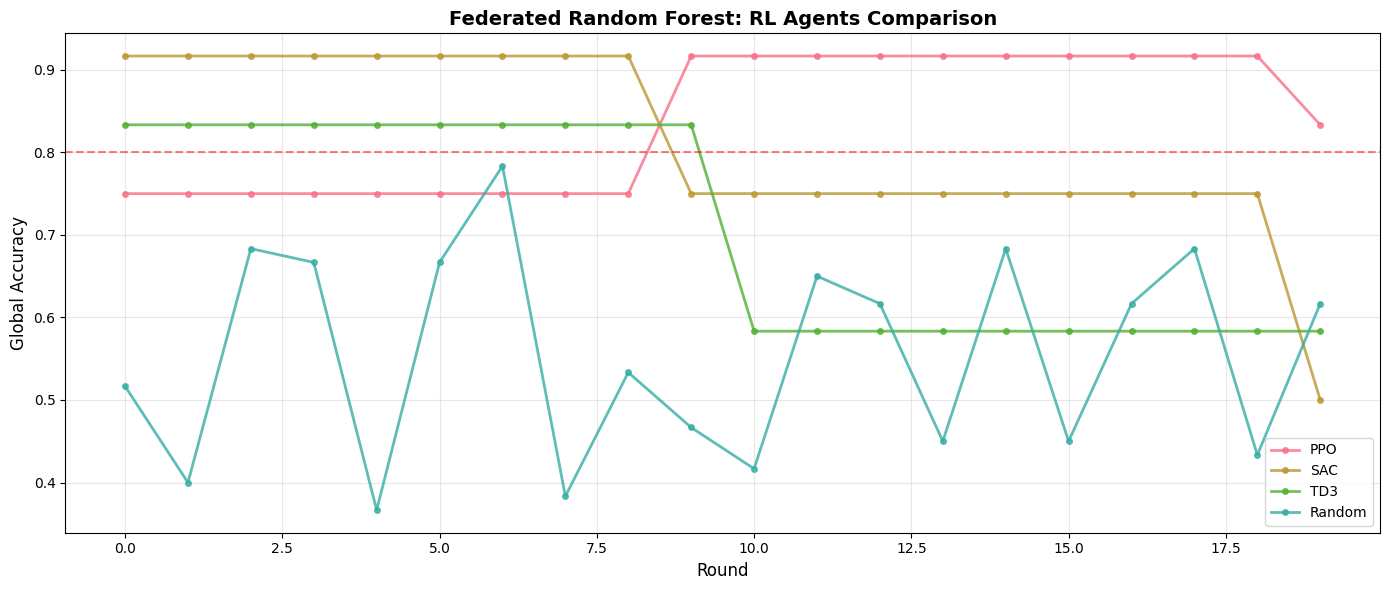

✅ Learning curves plotted and saved!


In [ ]:
# CELL 16: Plot Learning Curves for All Agents
# ============================================================================

plt.figure(figsize=(14, 6))

for agent_name, metrics in results.items():
    plt.plot(metrics['accuracies'], marker='o', linewidth=2,
             markersize=4, label=agent_name, alpha=0.8)

plt.xlabel('Round', fontsize=12)
plt.ylabel('Global Accuracy', fontsize=12)
plt.title('Federated Random Forest: RL Agents Comparison',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.80, color='red', linestyle='--', alpha=0.5, label='Target (80%)')

plt.tight_layout()
plt.savefig('rl_agents_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Learning curves plotted and saved!")


In [ ]:
# CELL 17: Create Metrics Comparison Table
# ============================================================================

# Compute summary statistics
summary = {}

for agent_name, metrics in results.items():
    accs = metrics['accuracies']
    rewards = metrics['rewards']

    summary[agent_name] = {
        'Final Accuracy': accs[-1],
        'Best Accuracy': max(accs),
        'Avg Accuracy': np.mean(accs),
        'Convergence Speed': np.argmax(np.array(accs) >= 0.75) + 1 if max(accs) >= 0.75 else len(accs),
        'Stability (Std)': np.std(accs[-5:]),
        'Avg Reward': np.mean(rewards),
        'Training Time (s)': metrics.get('training_time', 0)
    }

# Create DataFrame
df_summary = pd.DataFrame(summary).T

# Sort by final accuracy
df_summary = df_summary.sort_values('Final Accuracy', ascending=False)

print("\n📊 RL AGENTS COMPARISON SUMMARY")
print("="*80)
print(df_summary.to_string())
print("="*80)

# Save to CSV
df_summary.to_csv('rl_agents_summary.csv')
print("\n✅ Summary saved to 'rl_agents_summary.csv'")


KeyError: 'rewards'

KeyError: 'Random'

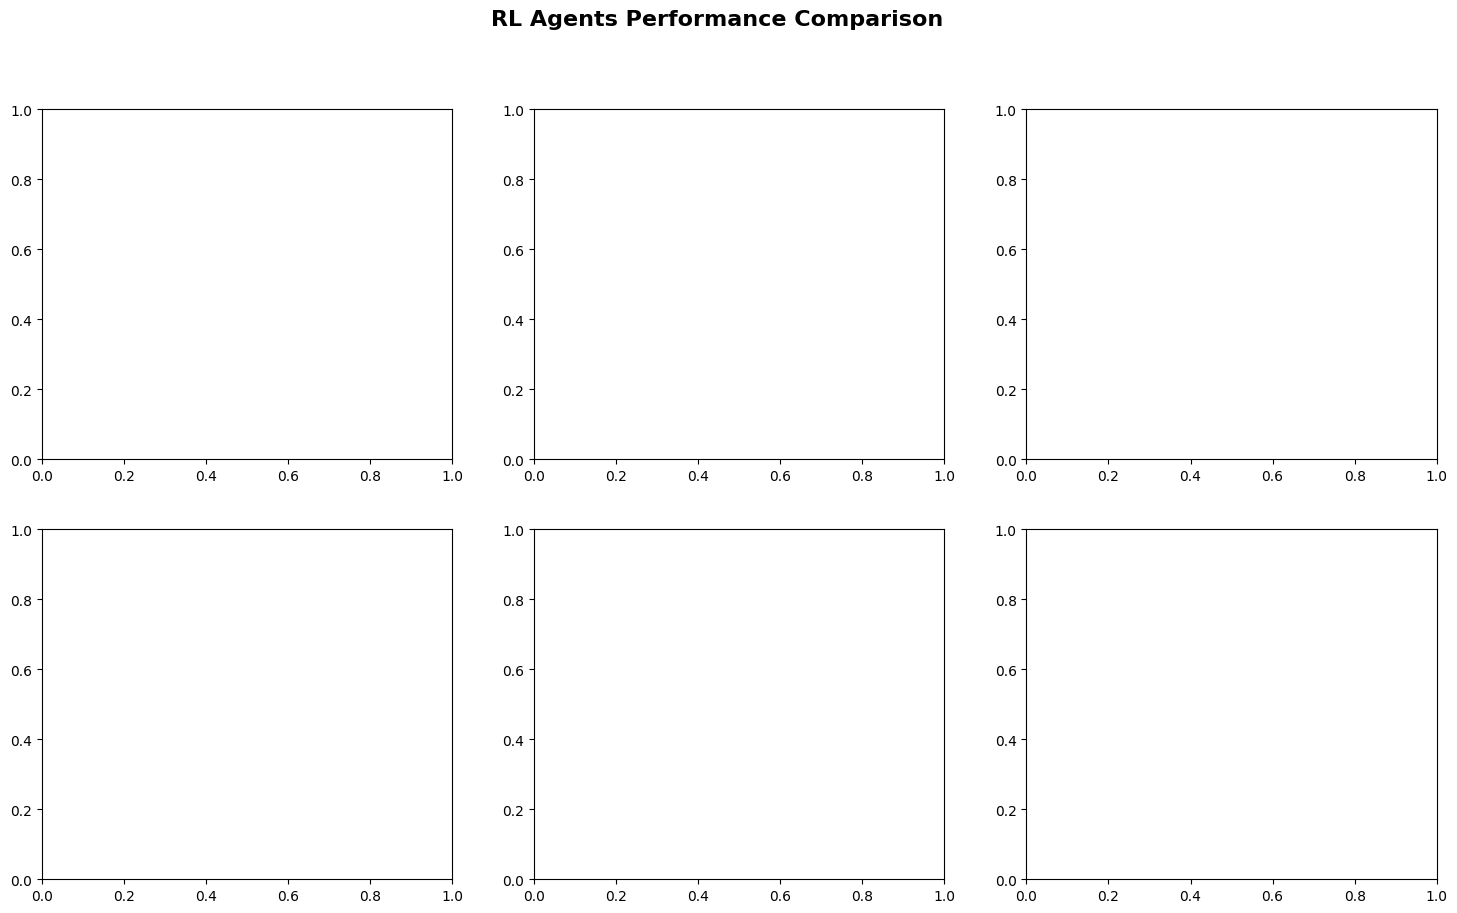

In [ ]:
# CELL 18: Comprehensive Comparison Visualization
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('RL Agents Performance Comparison', fontsize=16, fontweight='bold')

agents = list(results.keys())
colors = plt.cm.Set3(np.linspace(0, 1, len(agents)))

# 1. Final Accuracy
axes[0, 0].bar(agents, [summary[a]['Final Accuracy'] for a in agents], color=colors)
axes[0, 0].set_title('Final Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].axhline(y=0.80, color='red', linestyle='--', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Best Accuracy
axes[0, 1].bar(agents, [summary[a]['Best Accuracy'] for a in agents], color=colors)
axes[0, 1].set_title('Best Accuracy Achieved')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Convergence Speed (lower is better)
axes[0, 2].bar(agents, [summary[a]['Convergence Speed'] for a in agents], color=colors)
axes[0, 2].set_title('Convergence Speed')
axes[0, 2].set_ylabel('Rounds to 75% Accuracy')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Stability (lower is better)
axes[1, 0].bar(agents, [summary[a]['Stability (Std)'] for a in agents], color=colors)
axes[1, 0].set_title('Training Stability (Last 5 Rounds)')
axes[1, 0].set_ylabel('Std Dev')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Average Reward
axes[1, 1].bar(agents, [summary[a]['Avg Reward'] for a in agents], color=colors)
axes[1, 1].set_title('Average Reward')
axes[1, 1].set_ylabel('Reward')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Training Time
axes[1, 2].bar(agents, [summary[a]['Training Time (s)'] for a in agents], color=colors)
axes[1, 2].set_title('Training Time')
axes[1, 2].set_ylabel('Seconds')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rl_agents_detailed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive comparison visualization complete!")


KeyError: 'weights_history'

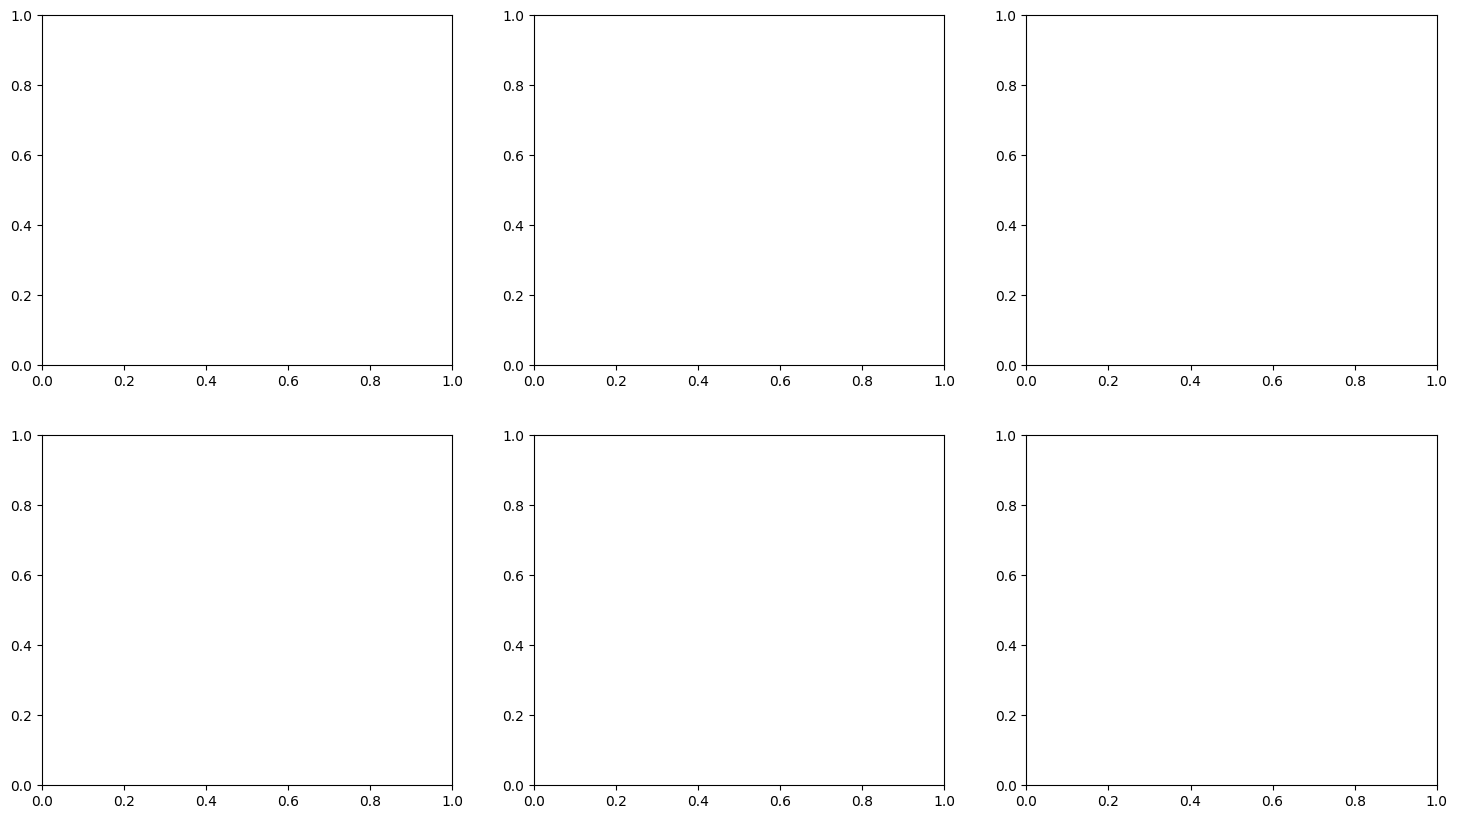

In [ ]:
# CELL 19: Analyze Client Weight Distribution
# ============================================================================

# Plot weight distributions for each agent
n_agents = len(results)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (agent_name, metrics) in enumerate(results.items()):
    if idx >= len(axes):
        break

    weights_history = np.array(metrics['weights_history'])

    # Plot each client's weight over time
    for client_idx in range(n_clients):
        axes[idx].plot(weights_history[:, client_idx],
                      label=f'Client {client_idx+1}',
                      linewidth=2, marker='o', markersize=3)

    axes[idx].set_title(f'{agent_name}: Client Weights', fontweight='bold')
    axes[idx].set_xlabel('Round')
    axes[idx].set_ylabel('Weight')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

# Remove unused subplots
for idx in range(n_agents, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('client_weights_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Client weight analysis complete!")


In [ ]:
# CELL 20: Save All Results
# ============================================================================

import pickle

# Create results directory
!mkdir -p results

# Save raw metrics
with open('results/all_metrics.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save summary CSV
df_summary.to_csv('results/summary.csv')

# Save individual agent results
for agent_name, metrics in results.items():
    df_agent = pd.DataFrame({
        'round': range(len(metrics['accuracies'])),
        'accuracy': metrics['accuracies'],
        'reward': metrics['rewards']
    })
    df_agent.to_csv(f'results/{agent_name}_metrics.csv', index=False)

print("✅ All results saved to 'results/' directory")
print("\nSaved files:")
print("  - all_metrics.pkl (complete metrics)")
print("  - summary.csv (comparison table)")
for agent in results.keys():
    print(f"  - {agent}_metrics.csv")


NameError: name 'df_summary' is not defined

In [ ]:
# Safety initialization for clients list to avoid IndexError
try:
    if 'clients' not in globals() or not isinstance(clients, list) or len(clients) == 0:
        print("Recreating clients list (was missing or empty)...")
        clients = []
        for i, data in enumerate(client_data):
            fc = FederatedClientMLP(
                client_id=i,
                X_local=data['X'],
                y_local=data['y']
            )
            clients.append(fc)
            print(f"Client {i} ready: {len(data['y'])} samples, {len(np.unique(data['y']))} classes")
    else:
        print(f"Existing clients list found: {len(clients)} clients")
except NameError:
    print("Variables not defined yet. Please run data split and client class cells first.")

# Select first client safely
if len(clients) > 0:
    test_client = clients[0]
    print("Selected test_client with id:", test_client.client_id)
else:
    print("No clients available even after recreation. Check earlier cells.")

In [ ]:
# Train test_client with global class count and display metrics
print("\n🚀 Starting test_client training with global classes...")
try:
    assert 'test_client' in globals(), "test_client not defined; run client selection cell first."
    assert 'n_global_classes' in globals(), "n_global_classes not defined; set it before training."
    model, metrics = test_client.train_local_model(
        n_epochs=10,
        batch_size=32,
        learning_rate=0.001,
        n_classes=n_global_classes
    )
    print("\n📊 Training Metrics (test_client):")
    for k, v in metrics.items():
        print(f"  {k}: {v}")
except Exception as e:
    print("❌ Training failed:", e)

In [ ]:
# Quick sanity test for new environment definition
try:
    assert 'clients' in globals() and len(clients) > 0, "Clients not initialized."
    test_env = FederatedAggregationEnv(clients, X_test, y_test)
    s, _ = test_env.reset()
    print("State shape:", s.shape)
    a = np.ones(len(clients)) / len(clients)
    ns, r, term, trunc, info = test_env.step(a)
    print("Step reward:", r, "Global acc:", info['global_accuracy'])
except Exception as e:
    print("❌ Environment sanity test failed:", e)